# Progetto A.A 2020-2021

<strong>Programmazione di Applicazioni Data Intensive</strong><br>
Arcara Alessio <br> alessio.arcara@studio.unibo.it <br> Matricola: 0900061028<br>
<a href="https://www.kaggle.com/aaron7sun/stocknews">Kaggle: Daily News for Stock Market Prediction</a>

## Introduzione

Il dataset scelto è composto da due file *csv* :
1. <strong>Stocks data</strong>: Indice Dow Jones Industrial Average (DJIA) composto dalle trenta imprese industriali statunitensi più redditizie del mercato. <br>*(Range: 2008-08-08 to 2016-07-01)*
2. <strong>News data</strong>: i titoli dei post dal canale Reddit WorldNews (<a href="https://www.reddit.com/r/worldnews/">/r/worldnews</a>). Sono classificate con i voti degli utenti reddit, e solo i 25 migliori titoli sono considerati per singolo giorno. <br>*(Range: 2008-06-08 to 2016-07-01)*

Le <strong>32</strong> colonne considerate sono le seguenti:
- "Date" (*intervallo*) $\rightarrow$ data giornaliera di scambio del titolo azionario,
- "Open, High, Low, Close, Adj Close" (*numerica*) $\rightarrow$ prezzo di apertura, chiusura e prezzo minimo, massimo giornaliero del titolo azionario.
- "Volume" (*ratio*) $\rightarrow$ quantità scambiata giornalmente del titolo azionario.
- "Top1,...,Top25" (*testo*) $\rightarrow$ i titoli dei migliori 25 post giornalieri del canale Reddit WorldNews.

Le istanze fornite sono <strong>1989</strong> e la variabile da predire "Label", che verrà creata e spiegata nel dettaglio nelle seguenti sezioni, è una variabile discreta multiclasse (-1, 0, 1). 

### È possibile prevedere il mercato?

Una "passeggiata aleatoria" è un fenomeno statistico in cui una variabile non segue un andamento distinguibile e si muove apparentemente in modo casuale. La teoria del <strong>random walk</strong>, applicata ai mercati finanziari, delineata più chiaramente da Burton Malkiel, postula che il prezzo dei titoli si muove casualmente, e che, quindi, ogni tentativo di prevedere il movimento futuro dei prezzi, attraverso l'analisi fondamentale o tecnica, è inutile.

L'obiettivo è generare modelli in grado di prevedere se l'indice DJIA avrà al giorno $t$ un movimento rialzista o ribassista, in modo da generare un profitto investendo in un fondo che si basi su tale indice.

Il progetto è suddiviso in due parti:<br>

1. Nella prima parte verranno utilizzati <strong>solo</strong> i dati storici sull'andamento dell'indice DJIA per generare una predizione al tempo $t$ sul movimento rialzista (1) o ribassista (-1);
2. Nella seconda parte si utilizzerà il testo dei titoli dei post per cercare una correlazione tra l'andamento dell'indice DJIA e notizie generiche attraverso il <strong>Natural Language Process</strong> (NLP) e dunque, migliorare i risultati precedentemente ottenuti;

### Installazione Librerie (Opzionale)

In [1]:
# !pip install wordcloud
# !pip install statsmodels
# !pip install prettytable

### Caricamento Librerie e Dati

In [2]:
rnd_state = 42

In [3]:
# Main
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, ShuffleSplit, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Visualization
from ipywidgets import interact
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn import set_config
import seaborn as sns
from wordcloud import WordCloud
from prettytable import PrettyTable

In [4]:
# Disattiviamo i warning per leggibilità
import warnings
warnings.filterwarnings("ignore")  # Ignore deprecations for cleaner output

# Plot styling
%matplotlib inline
figsize=(25, 6)
plt.style.use('fivethirtyeight')

In [5]:
set_config(display='diagram')

In [6]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("vader_lexicon")

[nltk_data] Downloading package punkt to
[nltk_data]     /home/alessoarcara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alessoarcara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alessoarcara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alessoarcara/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alessoarcara/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
stoplist = nltk.corpus.stopwords.words("english")
wnl = nltk.stem.WordNetLemmatizer()

In [8]:
stocks = pd.read_csv("./archive/upload_DJIA_table.csv", parse_dates=["Date"], index_col=["Date"])[::-1]
news = pd.read_csv("archive/Combined_News_DJIA.csv", parse_dates=['Date'], index_col=["Date"])

In [9]:
stocks.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1989 entries, 2008-08-08 to 2016-07-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1989 non-null   float64
 1   High       1989 non-null   float64
 2   Low        1989 non-null   float64
 3   Close      1989 non-null   float64
 4   Volume     1989 non-null   int64  
 5   Adj Close  1989 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 108.8 KB


In [10]:
news.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1989 entries, 2008-08-08 to 2016-07-01
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   1989 non-null   int64 
 1   Top1    1989 non-null   object
 2   Top2    1989 non-null   object
 3   Top3    1989 non-null   object
 4   Top4    1989 non-null   object
 5   Top5    1989 non-null   object
 6   Top6    1989 non-null   object
 7   Top7    1989 non-null   object
 8   Top8    1989 non-null   object
 9   Top9    1989 non-null   object
 10  Top10   1989 non-null   object
 11  Top11   1989 non-null   object
 12  Top12   1989 non-null   object
 13  Top13   1989 non-null   object
 14  Top14   1989 non-null   object
 15  Top15   1989 non-null   object
 16  Top16   1989 non-null   object
 17  Top17   1989 non-null   object
 18  Top18   1989 non-null   object
 19  Top19   1989 non-null   object
 20  Top20   1989 non-null   object
 21  Top21   1989 non-null   object
 22  Top22 

## 1. Stocks Data

### Preprocessing
#### Label dei dati
*(Fonte: Capitolo 3, Advances in Financial Machine Learning, Marcos López de Prado)*

I dati etichettati dicono al modello qual'è il risultato desiderato. Inoltre, se il modello effettua una predizione errata rispetto all'etichetta, si aggiusterà per avvicinarsi al risultato desiderato. <br>

Similmente, con le azioni, l'etichettatura del risultato fornisce al modello un indicazione sulla classificazione "<strong>Su</strong>" o "<strong>Giù</strong>" rispetto ai dati. Successivamente, l'idea è quella di classificare con "<strong>Su</strong>" o "<strong>Giù</strong>" nuovi dati non ancora visti.

Il metodo Naïve di etichettatura del risultato dell'andamento di un mercato finanziario è quello di basarsi solo sul <strong>segno</strong> del ritorno. Il principale svantaggio di quest'approccio è che non cattura la differenza di grandezza rispetto a due ritorni con lo stesso segno. *(0.01 ha lo stesso segno di 1000)*

Si potrebbe procedere aggiungendo una <strong>soglia</strong>, rispetto la quale si scelgono le etichette: <br><br>

<center>
$y_i= \begin{cases}
1 & r_{t_0, t_1} > \tau \\
0 & |{r_{t_0, t_1}}| \leq  \tau \\
-1 & r_{t_0, t_1} <  - \tau
\end{cases}$
</center>
<br>
Si migliora la precedente classificazione binaria, tuttavia la scelta della soglia statica assume che conseguentemente il mercato è statico. La varianza in un mercato finanziario è caratterizzata da un comportamento <strong>non costante</strong> <i>(volatility clustering)</i> e perciò per definizione l'andamento di un mercato finanziario è dinamico essendo una serie storica eteroschedatica.

Una soluzione è di introdurre una soglia dinamica basata sulla volatilità di $n$ periodi precedenti rispetto al prezzo di chiusura corrente. Si definisce la soglia come:

* $\pm\ \tau = $ Prezzo corrente $\pm$ volatilità $n$ periodi precedenti

In [11]:
def get_daily_vol(close, window=20):
    """
    Parameters:
    ---------------------
    close: (data frame) Closing Prices
    window: (int) periodo rispetto al quale calcolare volatility
    ---------------------
    Returns:
    ---------------------
    rolling std (data frame)
    ---------------------
    """
    print("Volatilità giornaliera per threshold dinamico")
    
    std = close.rolling(window).std()
    std.iloc[0:window] = close.iloc[0:window].std()
    
    return std

def get_label(close, std, threshold=1):
    """
    Parameters:
    ---------------------
    close: (data frame) Closing Prices
    std: (data frame) Rolling Std
    threshold: (int) Valore per controllare upper_bound, lower_bound
    ---------------------
    Returns:
    ---------------------
    Label (list)
    ---------------------
    """
    print("Etichettatura con threshold dinamico")
    
    upper_bound, lower_bound = close.shift(1)+std*threshold, close.shift(1)-std*threshold
    
    label = []
    for i in range(len(close)):
        if close.iloc[i] > upper_bound.iloc[i]:
            label.append(1)
        elif close.iloc[i] < lower_bound.iloc[i]:
            label.append(-1)
        else:
            label.append(0)
            
    return label

In [12]:
std = get_daily_vol(stocks["Close"])
label = pd.Series(get_label(stocks['Close'], std, 0.3) , name="Label").astype("category")

Volatilità giornaliera per threshold dinamico
Etichettatura con threshold dinamico


In [13]:
label.index = news.index

In [14]:
label.value_counts()

0     852
1     626
-1    511
Name: Label, dtype: int64

In [15]:
# One day returns calculation through differencing by 1
stocks["Delta"] = (stocks["Close"] - stocks["Close"].shift(1))/stocks["Close"].shift(1) * 100
stocks.iloc[0, -1] = 0

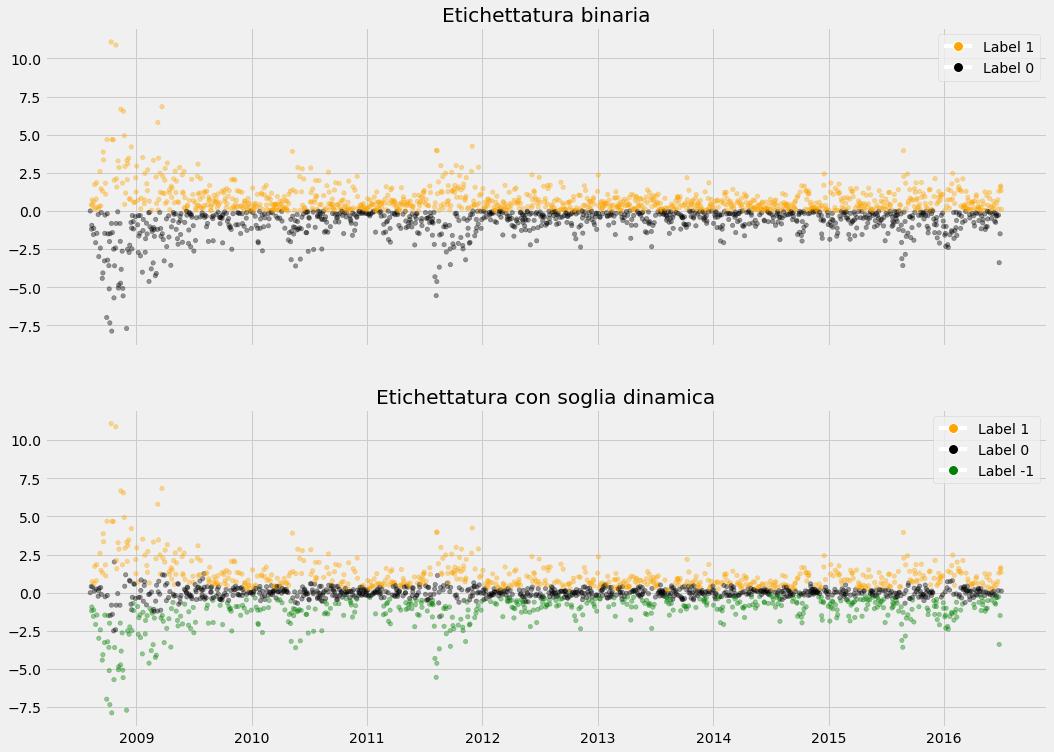

In [16]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, figsize=(16,12))
label_colors = {1: "orange", 0: "black", -1: "green"}

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Label 1', markerfacecolor='orange', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Label 0', markerfacecolor='black', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Label -1', markerfacecolor='green', markersize=10)]

ax1.scatter(stocks.index, stocks["Delta"], s=20, alpha=0.4, c=news["Label"].map(label_colors))
ax2.scatter(stocks.index, stocks["Delta"], s=20, alpha=0.4, c=label.map(label_colors));
ax1.set_title('Etichettatura binaria')
ax2.set_title('Etichettatura con soglia dinamica')
ax1.legend(handles=legend_elements[0:2], loc="upper right")
ax2.legend(handles=legend_elements, loc="upper right")
plt.show()

#### Stazionarietà e differenziazione
*(Fonte: Capitolo 5, Advances in Financial Machine Learning, Marcos López de Prado)*

Comunemente le serie storiche finanziarie sono non stazionarie. Una <strong>serie storica non stazionaria</strong> è una serie per cui proprietà come <u>media, varianza, autocorrelazione, etc cambiano nel tempo</u>. <br>
Ora immaginiamo una situazione dove i dati che abbiamo utilizzato per creare il nostro modello di conoscenza siano significativamente differenti rispetto ai dati a regime. Questo porterà probabilmente il nostro estimatore ad avere una bassa performance.<br>

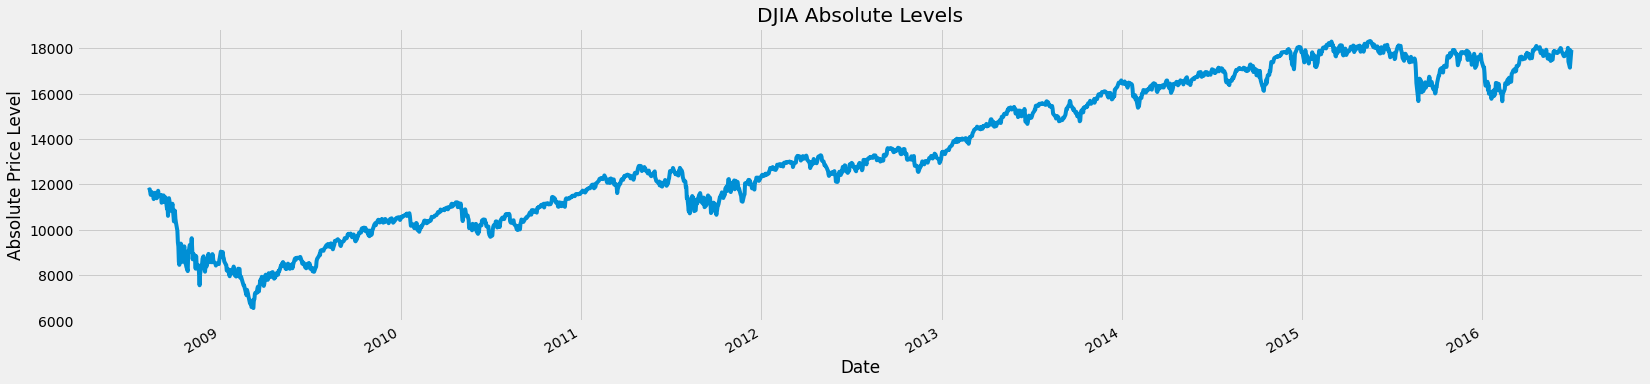

In [17]:
stocks["Adj Close"].plot(figsize=figsize)
plt.title('DJIA Absolute Levels');
plt.ylabel('Absolute Price Level')
plt.xlabel('Date');

Perciò, è auspicabile rendere la <strong>serie storica stazionaria</strong> mediante una o più trasformazioni, come per esempio trasformare i prezzi nei rendimenti di prezzo $y_t - y_{t-1}$.Tuttavia, queste trasformazioni rendono la serie stazionaria, a discapito di <u>perdere tutta la memoria</u> presente nella serie originale.<br>
Per memoria si intende come cambiamenti di osservazioni precedenti possono influenzare osservazioni future in un dato tempo. Se la serie avesse una forte memoria, analizzare il passato ci permetterebbe di ottenere informazioni su ciò che accade nel futuro.<br>

Text(0, 0.5, 'Daily Returns')

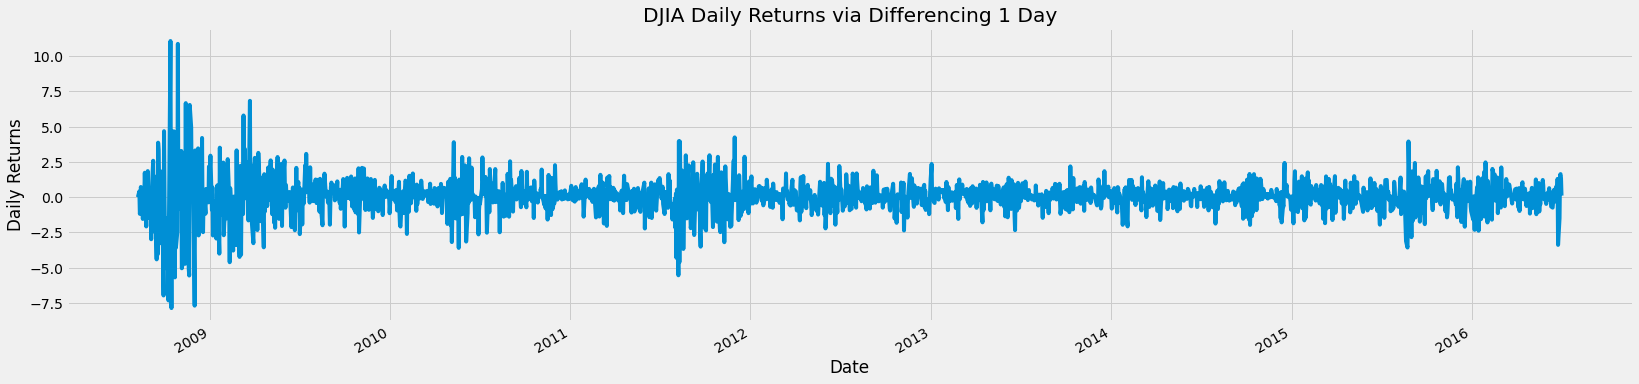

In [18]:
# Ritorni giornalieri
stocks["Delta"].plot(figsize=figsize)
plt.title(f'DJIA Daily Returns via Differencing 1 Day');
plt.ylabel('Daily Returns')

Verrà utilizzato un test statistico per controllare se la serie storica è stazionaria. il test, anche chiamato <strong>Augmented Dickey-Fuller</strong>, ha come ipotesi nulla che è presente un <strong>Unit root</strong>, ovvero che la serie storica modella un processo stocastico casuale, dove due valori qualsiasi di $y$ non hanno nessuna correlazione e sono effettivamente casuali. <u>Una serie storica con Unit root non è stazionaria</u>. <br><br>
Dunque, si utilizzerà la seguente funzione per controllare la stazionarità di una serie storica:

In [19]:
# test statistic < test statistic (1%) AND p-value < 0.01
# Reject the null hypothesis that there's unit root at the 1% significance level
# ==> Reject H0 ==> No unit root ==> Stationary

def adfuller_test(time_series, verbose=True):
    """
    Parameters:
    ---------------------
    time_series: (list) time series to evaluate
    ---------------------
    Returns:
    ---------------------
    null hypothesis (boolean)
    ---------------------
    """
    result = adfuller(time_series, regression='c')
    
    if verbose:
        print(f't-stat \n\t{result[0]:.2f}')
        print(f'p-value \n\t{result[1]:.2f}')
        print(f'Critical Values')
        for key, value in result[4].items():
            print(f'\t{key}: {value:.2f}')
        
    return True if result[0] > result[4]['1%'] or result[1] > 0.01 else False  

In [20]:
print(f'Null hypothesis: {adfuller_test(stocks["Adj Close"])}')

t-stat 
	-0.37
p-value 
	0.91
Critical Values
	1%: -3.43
	5%: -2.86
	10%: -2.57
Null hypothesis: True


In [21]:
print(f'Null hypothesis: {adfuller_test(stocks["Delta"])}')

t-stat 
	-10.63
p-value 
	0.00
Critical Values
	1%: -3.43
	5%: -2.86
	10%: -2.57
Null hypothesis: False


Come possiamo vedere, il test statistico conferma ciò precedentemente descritto.

Per rendere la serie storica stazionaria e <u>minimizzare la perdita di memoria</u> si utilizzerà <strong>fractional differencing</strong>, introdotto per la prima volta nella pubblicazione scientifica <a href="https://www.jstor.org/stable/2335817">“Fractional Differencing”</a> da J. R. M. Hosking.

Denotiamo $B$ come operatore di spostamento all'indietro, una notazione che ci permette di scrivere in maniera compatta precedenti osservazioni della serie storica, dove ad esempio $B^kX_t=X_{t-k}$ per $k\geq0$ e $t>1$. I polinomi con questo tipo di operatore possono essere visti come una applicazione ripetuta dello spostamento all'indietro, ad esempio $B^2X_t=X_{t-2}$. <br>In un modello frazionario, l'esponente $d$ in $(1-B)^d$ può essere un numero reale, con la seguente espansione binomiale:

$$(1-B)^d=\sum_{k=0}^\infty\binom d k (-B)^k$$
$$=\sum_{k=0}^\infty\frac{\prod_{i=0}^{k-1}(d-i)(-B)^k}{k!}$$
$$=1-dB+\frac{d(d-1)}{2!}B^2-\frac{d(d-1)(d-2)}{3!}B^3+...$$

<br>
Consideriamo ora la serie $X_t$ con l'operatore di spostamento $(1-B)^d$:<br><br>
$$(1-B)^dX_t=X_t-dBX_t+\frac{d(d-1)}{2!}B^2X_t-...$$

Che può essere riscritta come:
$$X_t=X_t-dX_{t-1}+\frac{d(d-1)}{2!}X_{t-2}-...$$

$$\tilde{X}_t=\sum_{k=0}^\infty w_kX_{t-k}$$
<br>
<center>dove $w=${$1, -d, \frac{d(d-1)}{2!},...$} e $X=${$X_t, X_{t-1}, ...$}</center>

Possiamo perciò generare i pesi iterativamente come: 
$$w_k=-w_{k-1}\frac{d-k+1}{k}$$

<ul>
    <li>Quando $d$ è un numero intero, $\forall k>d = 0$ e la memoria dopo quel punto è azzerata, ad esempio $d=1$ $w=\{1, -1, 0, 0\}$</li>
    <li>I pesi convergono a zero, $w_k\rightarrow 0$</li>
    <li>L'alternanza del segno dei pesi è necessaria per mantenere la serie storica stazionaria</li>
</ul>

Plot weights [w] for each lag [k] for varying differencing value [d]
Calcolo pesi [w] per ogni lag [k] come w_k = -w_(k-1) * (0.0 - k + 1)/k.
Calcolo pesi [w] per ogni lag [k] come w_k = -w_(k-1) * (0.25 - k + 1)/k.
Calcolo pesi [w] per ogni lag [k] come w_k = -w_(k-1) * (0.5 - k + 1)/k.
Calcolo pesi [w] per ogni lag [k] come w_k = -w_(k-1) * (0.75 - k + 1)/k.
Calcolo pesi [w] per ogni lag [k] come w_k = -w_(k-1) * (1.0 - k + 1)/k.


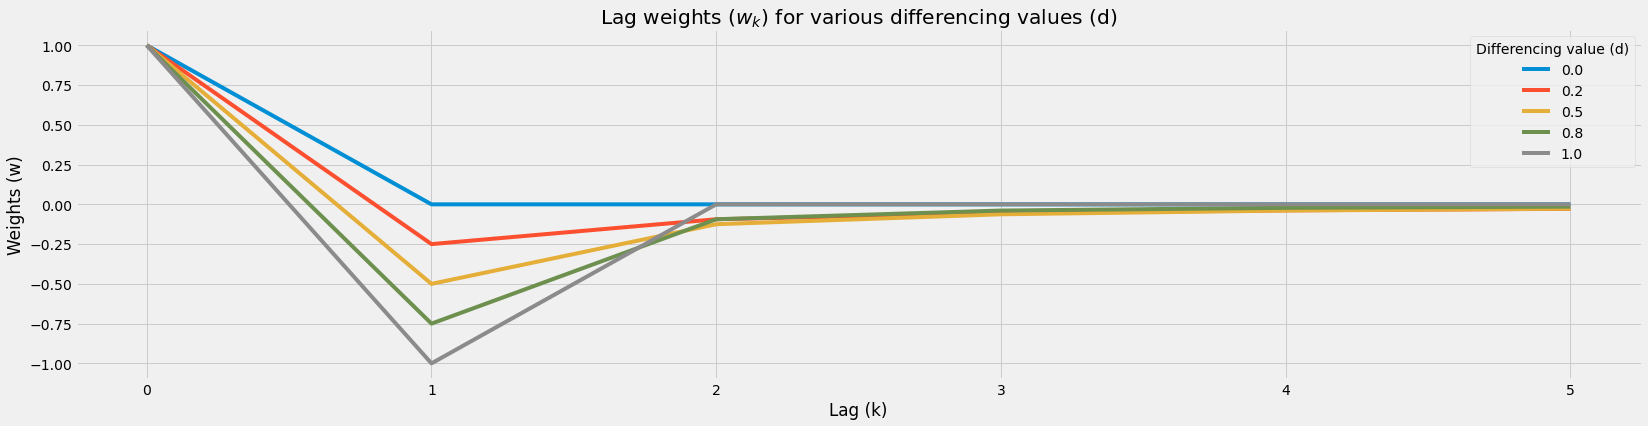

In [22]:
def get_weights(d, num_k):
    """
    Parameters:
    ---------------------
    d: (int) differencing value
    num_k: (int) number of lags (typically length of timeseries) to calculate w
    ---------------------
    Returns:
    ---------------------
    Label (list)
    ---------------------
    """
    print(f'Calcolo pesi [w] per ogni lag [k] come w_k = -w_(k-1) * ({d} - k + 1)/k.')
    
    w_k = np.array([1])
    
    for k in range(1, num_k):
        w_k = np.append(w_k, -w_k[-1] * ((d - k + 1)) / k)
        
    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def plot_weights(range_d, num_k, num_d_interval):
    """    
    Parameters:
    ---------------------
    range_d (list): range of differencing values to plot.
    num_k (int): number of lags (typically length of timeseries) to plot.
    num_d_interval (int): number of d interval.
    ---------------------
    Returns:
    ---------------------
    Weight for each d (dataframe)
    ---------------------
    """
    print("Plot weights [w] for each lag [k] for varying differencing value [d]")
    # Get differencing values
    interval = np.linspace(range_d[0], range_d[1], num_d_interval)
    
    # Dataframe of lags (rows) * number of differencing intervals (columns)
    df_wk = pd.DataFrame(np.zeros((num_k, num_d_interval)))
    
    # Get weights array per differencing value
    for i, d in enumerate(interval):
        df_wk[i] = get_weights(d, num_k)
        
    # Rename columns for legend
    df_wk.columns = [round(x, 1) for x in interval]
    
    # Plot
    df_wk.plot(figsize=figsize)
    plt.title('Lag weights ($w_k$) for various differencing values (d)')
    plt.legend(title='Differencing value (d)')
    plt.ylabel('Weights (w)')
    plt.xlabel('Lag (k)')
    plt.show()
    
    # Return weights
    return df_wk

df_wk = plot_weights(range_d=[0, 1], num_k=6, num_d_interval=5)


In [23]:
df_wk

,0.0,0.2,0.5,0.8,1.0
0,1.0,1.000000,1.000000,1.000000,1.0
1,-0.0,-0.250000,-0.500000,-0.750000,-1.0
2,-0.0,-0.093750,-0.125000,-0.093750,0.0
3,-0.0,-0.054688,-0.062500,-0.039062,0.0
4,-0.0,-0.037598,-0.039062,-0.021973,0.0
5,-0.0,-0.028198,-0.027344,-0.014282,0.0


Come si vede dal seguente grafico, alti valori di $d$ fanno decadere più velocemente la somma cumulativa del peso $w_k$, denotando una perdita di informazione maggiore rispetto alle osservazioni precedenti $X_{t-k}$.

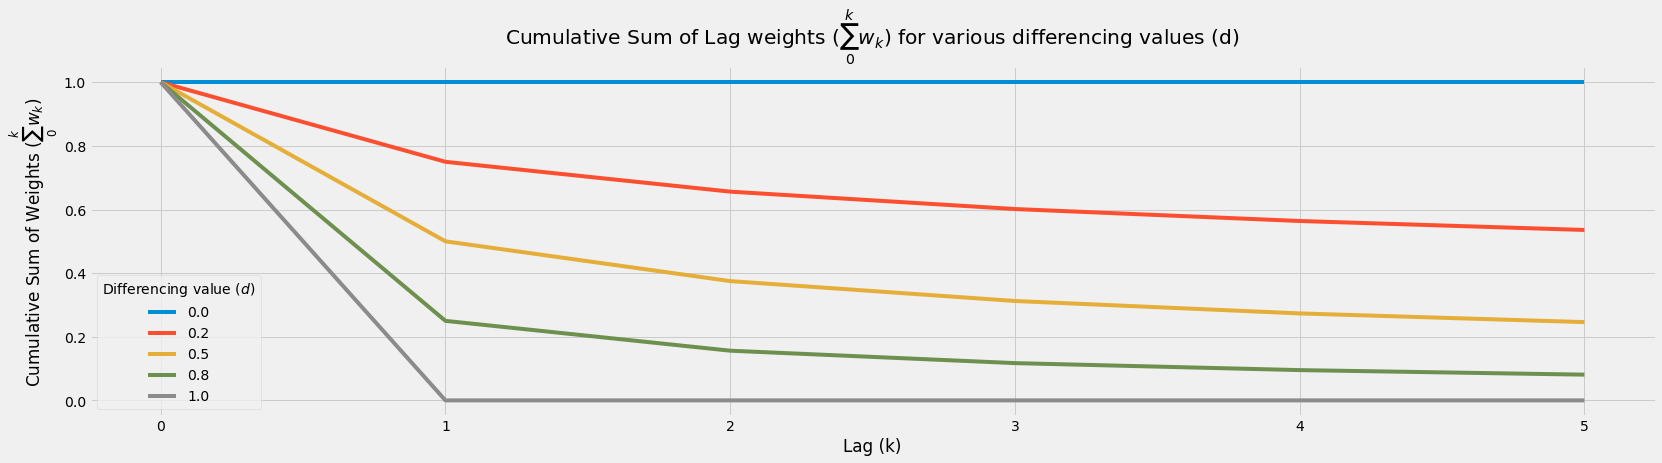

In [24]:
df_wk.cumsum().plot(figsize=figsize)
plt.title('Cumulative Sum of Lag weights ($\sum_0^k w_k$) for various differencing values (d)')
plt.legend(title='Differencing value ($d$)')
plt.ylabel('Cumulative Sum of Weights ($\sum_0^k w_k$)')
plt.xlabel('Lag (k)');

Per efficienza computazionale, se $|w_k|$ cade sotto un certo <strong>threshold</strong> si termina la computazione della funzione.<br> In altre parole, calcoliamo i primi $l*$ dove $|w_{l*}|\geq \tau$ e $|w_{l*+1}|\leq \tau$ tale che avremo:

$\tilde{w_k}=\begin{cases}
w_k & k\leq l* \\ 
0 & k>l*
\end{cases}$

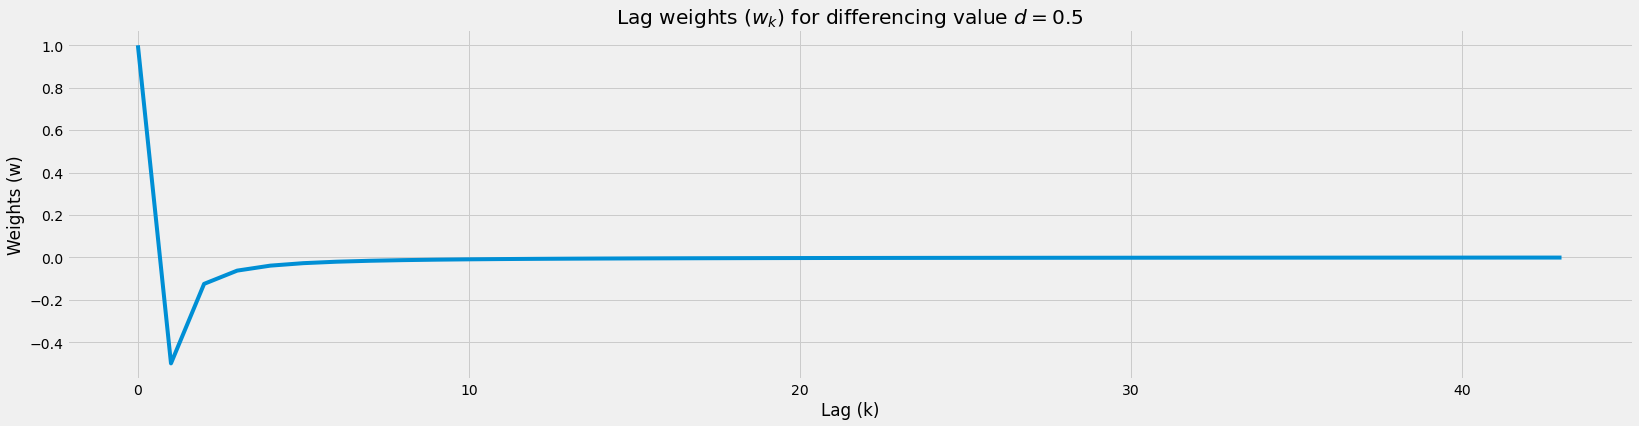

In [25]:
def get_weights_floored(d, num_k, floor=1e-3):
    """    
    Calculate weights [w] for each lag [k] through come $w_k = -w_(k-1) * (d - k + 1)/k$
    above a minimum value (floor) for the weights to prevent computation of weights for the entire time series
    
    Parameters:
    ---------------------
    d (int): differencing value.
    num_k (int): number of lags (typically length of timeseries) to calculate w.
    floor (float): minimum value for the weights for computational efficiency.
    ---------------------
    Returns:
    ---------------------
    Weight for each d (dataframe)
    ---------------------
    """
          
    w_k = np.array([1])
    k = 1
    
    while k < num_k:
        w_k_latest = -w_k[-1] * ((d - k + 1)) / k
        if abs(w_k_latest) <= floor:
            break

        w_k = np.append(w_k, w_k_latest)
        k += 1

    w_k = w_k.reshape(-1, 1) 
    return w_k

d = 0.5
num_k = 1000
weights = get_weights_floored(d=d, num_k=num_k)
pd.DataFrame(weights).plot(legend=False, figsize=figsize)

# Plot
plt.title(f'Lag weights ($w_k$) for differencing value $d={d}$')
plt.ylabel('Weights (w)')
plt.xlabel('Lag (k)');

In [26]:
def frac_diff(df, d, floor=1e-3):
    """
    Fractionally difference time series.
    
    Parameters:
    ---------------------
    df (dataFrame): dataframe of raw time series values.
    d (float): differencing value from 0 to 1.
    floor (float): minimum value of weights, ignoring anything smaller.
    ---------------------
    Returns:
    ---------------------
    Weight for each d (dataframe)
    ---------------------
    """
    # Get weights window
    weights = get_weights_floored(d=d, num_k=len(df), floor=floor)
    weights_window_size = len(weights)
    
    # Reverse weights
    weights = weights[::-1]
    
    # Blank fractionally differenced series to be filled
    df_fd = []
    df_date = []

    # Slide window of time series, to calculated fractionally differenced values
    # per window
    for idx in range(weights_window_size, df.shape[0]):
        # Extract datetime from timestamp
        df_date.append(df.index[idx])
        # Dot product of weights and original values
        # to get fractionally differenced values
        df_fd.append(np.dot(weights.T, df.iloc[idx - weights_window_size:idx]).item())
    
    return pd.DataFrame(data=df_fd, index=df_date, columns=[df.name])

@interact(d=np.linspace(0, 1, 9))
def show_plot(d=0.1):
    df_raw_fd = frac_diff(stocks["Adj Close"], d=d, floor=5e-5)
    
    # Plot
    df_raw_fd.plot(figsize=figsize);
    plt.title(f'Time series differencing for value $d={d}$')
    plt.show()

interactive(children=(Dropdown(description='d', options=(0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0…

Data la funzione per eseguire il procedimento appena descritto, verrà costruita una funzione ricorrente <strong>min_d_frac_diff</strong> che calcolerà il valore $d$ che minimizza la perdita di memoria e rende stazionaria la serie storica. Questa, successivamente, verrà utilizzata nel <i>FunctionTransformer</i> di Scikit-Learn per trasformare le serie storiche non stazionarie.

In [27]:
def min_d_frac_diff(df, d=0):
    print(f"column: {df.name}, differencing value: {round(d, 2)}")
    df_raw_fd = frac_diff(df, d=d, floor=5e-5)
    if not adfuller_test(df_raw_fd, verbose=False):
        return df_raw_fd
    elif d >= 1:
        return df_raw_fd 
    else:
        return(min_d_frac_diff(df, d=d+0.05))
    
# Slide window of time series can be different, so dropna is necessary to make each column length equal
def multiple_columns_min_fd(df):
    print(f"*** multiple columns fractional differencing ***")
    return pd.concat([min_d_frac_diff(df[column]) for column in df], axis=1).dropna()

In [28]:
TimeSeriesTansformer = FunctionTransformer(multiple_columns_min_fd)

In [29]:
df_stocks = TimeSeriesTansformer.fit_transform(stocks.iloc[:,:-1])

*** multiple columns fractional differencing ***
column: Open, differencing value: 0
column: Open, differencing value: 0.05
column: Open, differencing value: 0.1
column: Open, differencing value: 0.15
column: Open, differencing value: 0.2
column: Open, differencing value: 0.25
column: High, differencing value: 0
column: High, differencing value: 0.05
column: High, differencing value: 0.1
column: High, differencing value: 0.15
column: High, differencing value: 0.2
column: High, differencing value: 0.25
column: Low, differencing value: 0
column: Low, differencing value: 0.05
column: Low, differencing value: 0.1
column: Low, differencing value: 0.15
column: Low, differencing value: 0.2
column: Low, differencing value: 0.25
column: Close, differencing value: 0
column: Close, differencing value: 0.05
column: Close, differencing value: 0.1
column: Close, differencing value: 0.15
column: Close, differencing value: 0.2
column: Close, differencing value: 0.25
column: Volume, differencing value:

Da notare come nell'esercitazione sulla borsa sono state derivate due ulteriori variabili indipendenti come $\Delta H_t = H_t - H_{t-1}$ e $\Delta L_t = L_t - L_{t-1}$ per diversi $t$. Con il procedimento appena descritto, in altre parole, ogni variabile $X$ al tempo $t$ è combinazione rispetto ai valori <strong>pesati</strong> di $X_{t-k}$.

Sulla base del fenomeno del <a href="https://www.investopedia.com/terms/w/weekendeffect.asp">Monday Effect</a> e del detto <a href="https://www.investopedia.com/terms/s/sell-in-may-and-go-away.asp">"Sell in May and go away"</a> andremo a derivare due ulteriori variabili dalla data giornaliera. Per <i>Monday Effect</i> si intende un fenomeno per cui i ritorni azionari al lunedì sono spesso minori rispetto ai giorni che precedono venerdì. Mentre per <i>"Sell in May and go away"</i> è un detto che suggerisce agli investitori di disinvestire a Maggio e di reinvestire a Novembre.<br>
Senz'altro si basano sul <strong>comportamento irrazionale</strong> del mercato finanziario e dei suoi agenti, ma è da notare come dal 1950 al 2013 l'indice DJIA, preso da noi in considerazione, ha proprio sottoperformato nel periodo da Maggio a Ottobre rispetto al periodo da Novembre ad Aprile.<br> Pertanto, è interessante aggiungere queste due variabili e vedere come verranno interpretate dai modelli che utilizzeremo.

In [30]:
stocks['month'] = stocks.index.month
stocks['weekday'] = [datetime.strptime(str(stocks.index[row]), '%Y-%m-%d %H:%M:%S').weekday() for row, _ in enumerate(stocks.itertuples())]
stocks['semes'] = abs((stocks.month.astype(int) - 3) // 6)

In [31]:
df_stocks['month'] = stocks['month'].reindex_like(df_stocks)
df_stocks['weekday'] = stocks['weekday'].reindex_like(df_stocks)
df_stocks['semes'] = stocks['semes'].reindex_like(df_stocks)

Infine, si aggiunge la variabile *label* precedentemente calcolato a *df_stocks*:

In [32]:
df_stocks["Label"] = label

### Analisi Esplorativa

Dopo un attento lavoro di preprocessing, analizzando le serie storiche trasformate attraverso fractional differencing, si nota che "Open", "High", "Low", "Close" sono fortemente correlate l'una con l'altra. Questo è naturale, dato che descrivono esattamente l'andamento di prezzo nei suoi valori di apertura, chiusura, minimo e massimo.

In [33]:
df_stocks.iloc[:,:5].describe()

,Open,High,Low,Close,Volume
count,1215.000000,1215.000000,1215.000000,1215.000000,1.215000e+03
mean,2592.667876,2605.199639,2579.766270,2593.598897,7.997662e+07
std,399.513247,390.801266,403.468549,399.894056,4.674681e+07
min,1175.790773,1196.282012,974.465374,1175.549864,-3.827092e+07
25%,2289.453313,2298.653209,2280.041144,2291.429359,5.514961e+07
50%,2684.107050,2716.053357,2664.629516,2682.332552,7.148134e+07
75%,2901.241799,2916.243042,2892.747794,2902.371369,9.134669e+07
max,3332.169940,3315.585307,3371.405251,3322.714812,6.275969e+08


Text(0, 0.5, 'Absolute Levels')

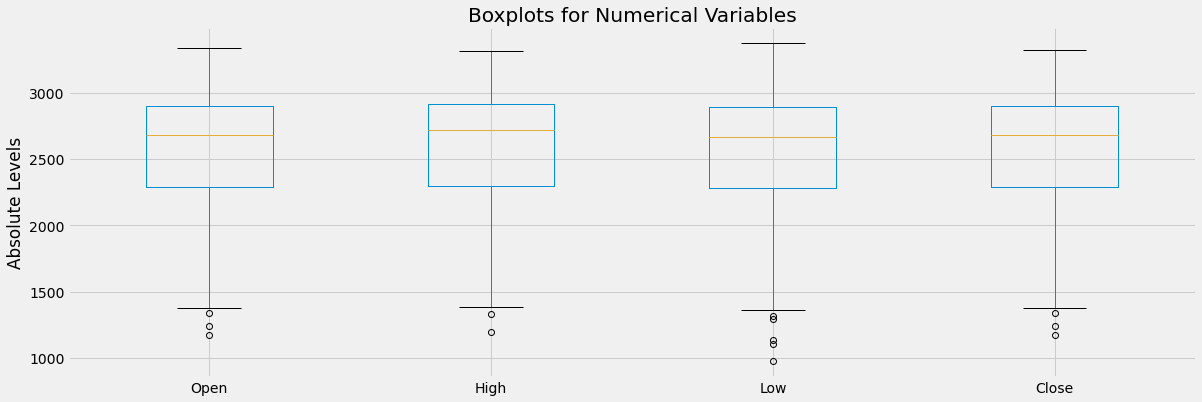

In [34]:
df_stocks.iloc[:,:4].plot.box(figsize=(18, 6))
plt.title("Boxplots for Numerical Variables")
plt.ylabel("Absolute Levels")

Inoltre, si nota che il volume è una variabile indipendente con deviazione standard piuttosto alta, che trova spiegazione nella realtà dal fatto che per ogni picco o crollo di prezzo, il volume sostiene l'andamento di prezzo, fino a un assestamento di prezzo. Per l'<strong>analisi tecnica</strong> il volume è estremamente importante, poichè in presenza di un picco se il venduto supera il comprato troviamo una <i>resistenza</i>, altrimenti in caso di crollo se il comprato supera il venduto abbiamo un <i>supporto</i>. Dunque, possiamo vedere il volume come una combinazione di due forze, ovvero il venduto e il comprato.

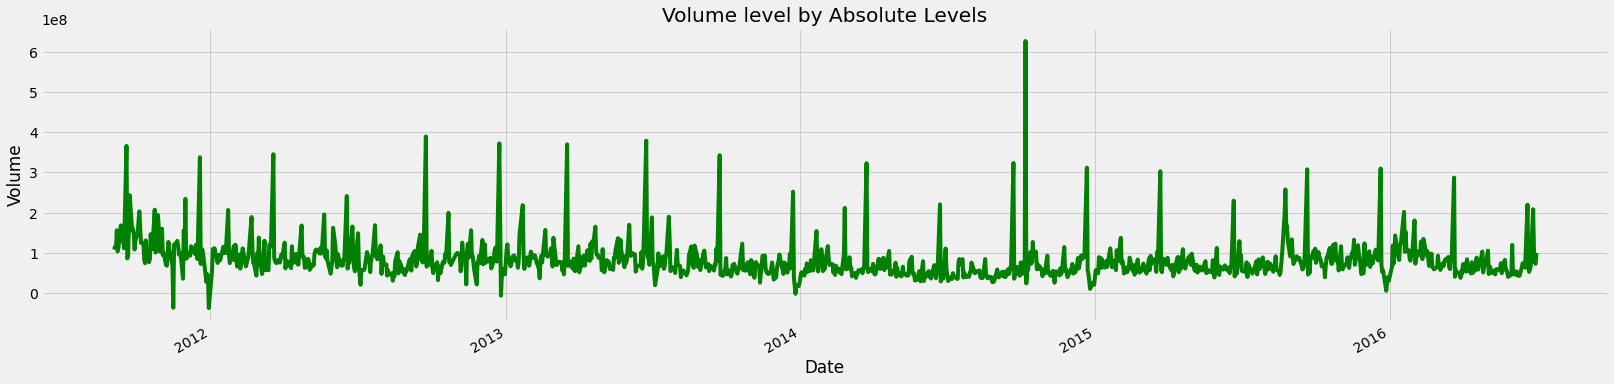

In [35]:
df_stocks["Volume"].plot(figsize=figsize, color="green")
plt.title('Volume level by Absolute Levels');
plt.ylabel('Volume')
plt.xlabel('Date');

La visualizzazione delle distribuzioni delle variabili numeriche indica che le serie storiche su cui abbiamo effettuato il fractional differencing <u>non</u> hanno una <strong>distribuzione normale</strong> essendo asimmetriche o avendo un eccessiva curtosi. Aumentando il coefficiente $d$ del fractional differencing, si otterrebbero delle distribuzioni normali a scapito però di perdita importante di memoria sulle serie storiche.

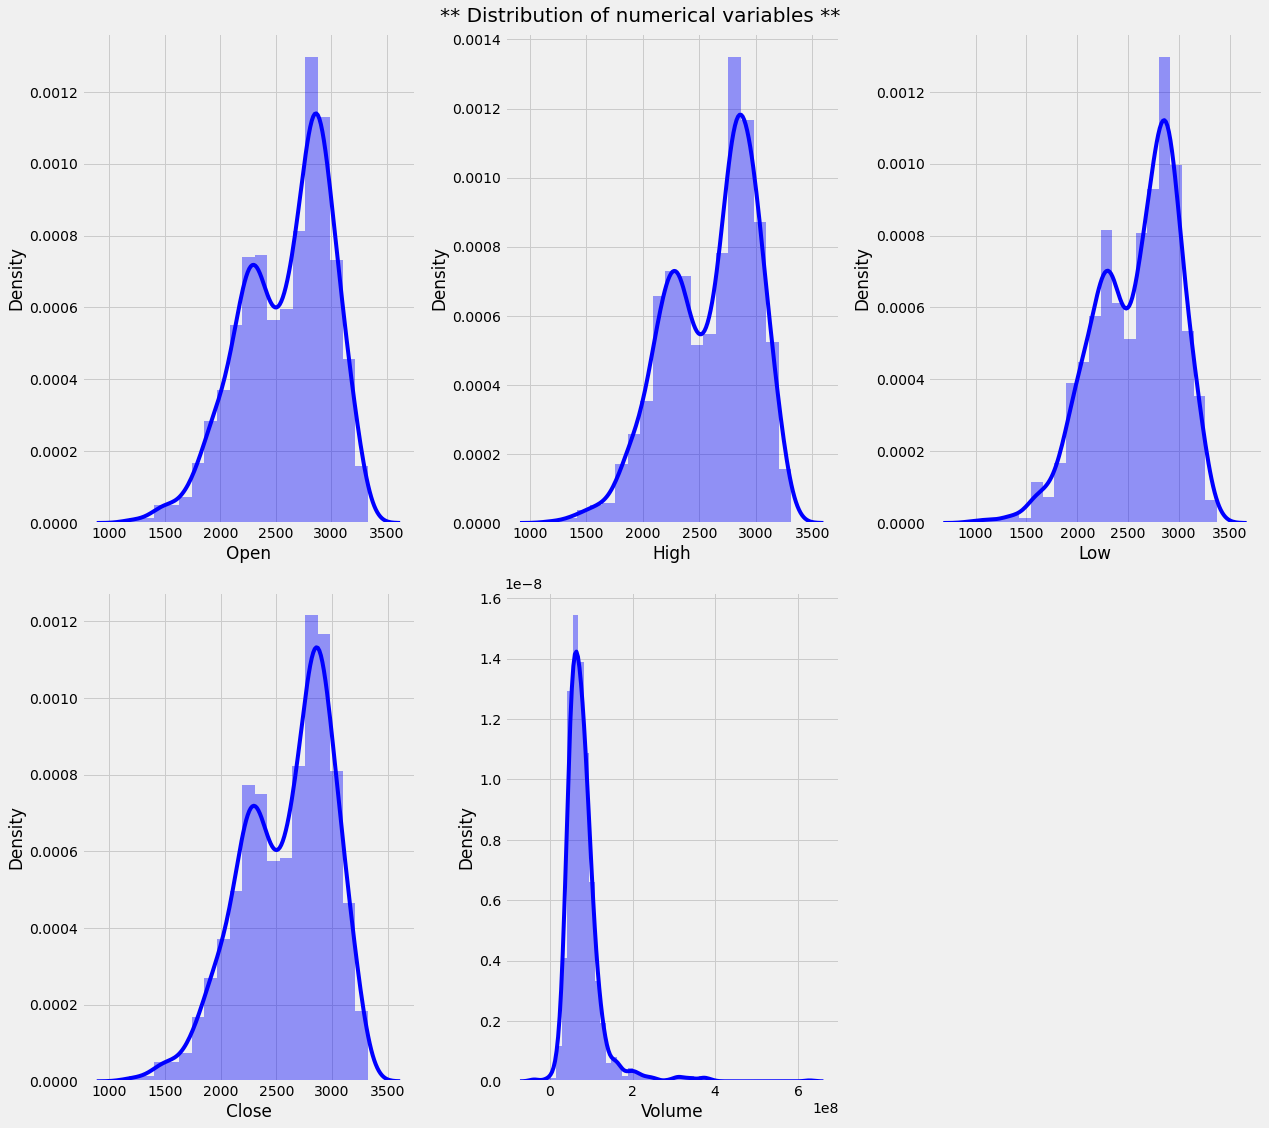

In [36]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 16))
fig.suptitle('** Distribution of numerical variables **', fontsize=20)


for col, ax in zip(df_stocks.iloc[:,:5], axes.flat):
    sns.distplot(df_stocks[col], color="blue", hist=True, ax=ax)
    
fig.tight_layout()
fig.delaxes(axes[1, 2])

Visualizzando con un grafico a torta la distribuzione delle classi della variabile dipendente si nota un buon bilanciamento. Tuttavia, il bilanciamento verrebbe a mancare nel caso utilizzassimo una soglia per l'etichettatura maggiore, infatti la classe "neutrale" predominerebbe sul resto delle classi.

0     512
1     385
-1    318
Name: Label, dtype: int64


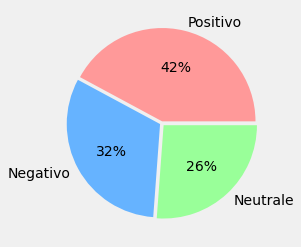

In [37]:
labels = ["Positivo", "Negativo", "Neutrale"]
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.02,0.02,0.03)
plt.pie(df_stocks["Label"].value_counts(), labels = labels, colors = colors, autopct='%.0f%%', explode = explode);

print(df_stocks["Label"].value_counts())

Il detto <i>"Sell in May, go away, come again St. Leger's day (September 15)"</i> non viene confermato dalla distribuzione delle classi. Tuttavia, il treshold da noi impostato (0.2) è piuttosto basso, con poca significativà dunque della grandezza del segno. Impostando un treshold poco più alto (0.3), si conferma la presenza di un numero più alto di giorni con andamento positivo e di grandezza maggiore.

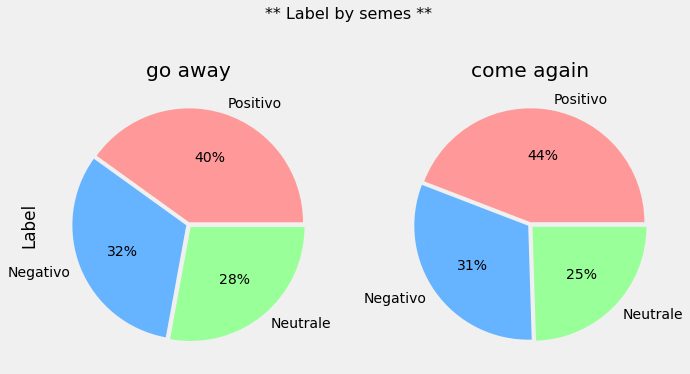

In [38]:
semes_labels = { 0: "go away", 1: "come again" }
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 6), sharey=True)
fig.suptitle('** Label by semes **', fontsize=16)

for i, ax in enumerate(axes.flat):
    df_stocks["Label"].groupby(df_stocks["semes"]).value_counts()[i].plot.pie(
        title=semes_labels[i],
        autopct='%.0f%%',
        ax=ax,
        labels=labels,
        colors=colors,
        explode=explode) 

Approfondendo l'analisi ai mesi e ai giorni della settimana, si conferma anche la presenza del <i>"Monday Effect"*</i>, ovvero rendimenti minori nella giornata di lunedì piuttosto che nei giorni che precedono venerdì. Una possibile spiegazione del fenomeno è la tendenza delle aziende a rilasciare cattive notizie dopo il venerdì, dopo che le borse hanno chiuso, deprimendo i prezzi al lunedì.

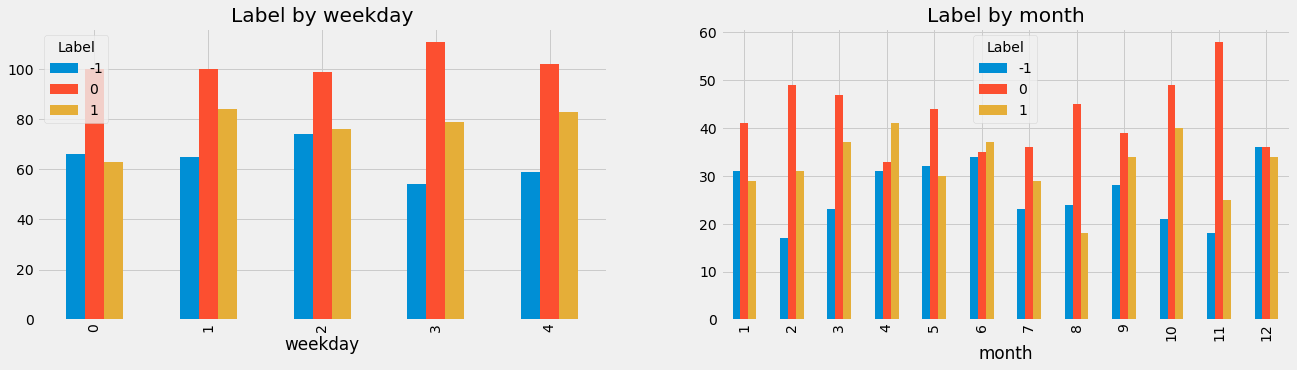

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

df_stocks["Label"].groupby(df_stocks["weekday"]).value_counts().unstack().plot(kind='bar', title="Label by weekday", ax=ax1);
df_stocks["Label"].groupby(df_stocks["month"]).value_counts().unstack().plot(kind='bar', title="Label by month", ax=ax2);

Per di più, emerge dal seguente insieme di grafici, anche una possibile seconda spiegazione. il maggior volume al lunedì può giustificare forze di arbitraggio che riducono il profitto per gli agenti e un <strong>minor rapporto segnale/rumore</strong>. Difficile invece, poter trarre delle informazioni dal volume per mese e volume per semestre se non la minore quantità di scambi nei mesi estivi.

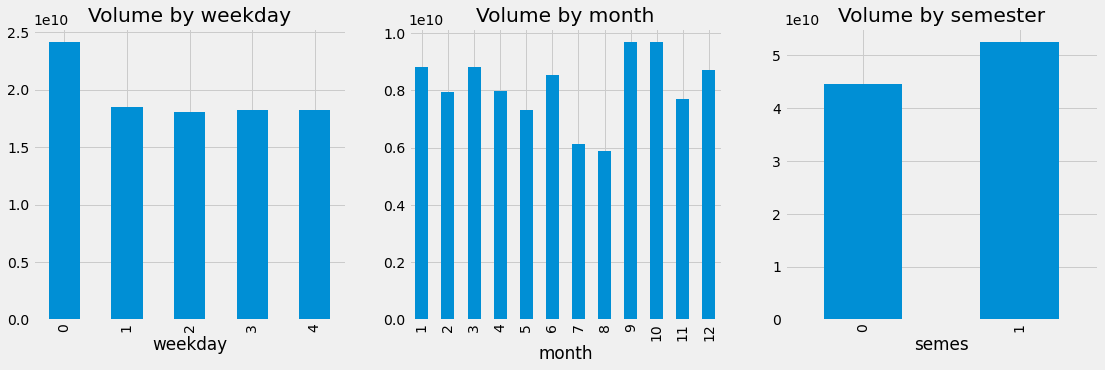

In [40]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

df_stocks["Volume"].groupby(df_stocks["weekday"]).sum().plot(kind="bar", title="Volume by weekday", ax=ax1)
df_stocks["Volume"].groupby(df_stocks["month"]).sum().plot(kind="bar", title="Volume by month", ax=ax2)
df_stocks["Volume"].groupby(df_stocks["semes"]).sum().plot(kind="bar", title="Volume by semester", ax=ax3);

Poichè le feature non seguono una distribuzione normale si andrà ad applicare la <strong>correlazione di Spearman</strong> per controllare la correlazione tra le feature.<br><br>
Viene confermato dalla correlazione negativa tra volume e le altre feature. Infatti, periodi di ipervenduto e perciò di alto volume corrispondono a periodi di crisi finanziarie con conseguente crollo dei prezzi.<br>
Infine, si rileva un'<strong>alta dipendenza</strong> tra le feature <i>"Open", "Close", "Low" e "High</i>, delineando <strong>collinearità</strong> tra le variabili indipendenti. Questo è un problema, poichè causa modelli, soprattutto nella regressione ordinaria, instabili, dove piccole variazioni tra i dati possono generare modelli molto diversi e inaffidabili. <br>
Mediante la regolarizzazione risolviamo il problema poichè vincoliamo le possibili soluzioni intorno all'origine.

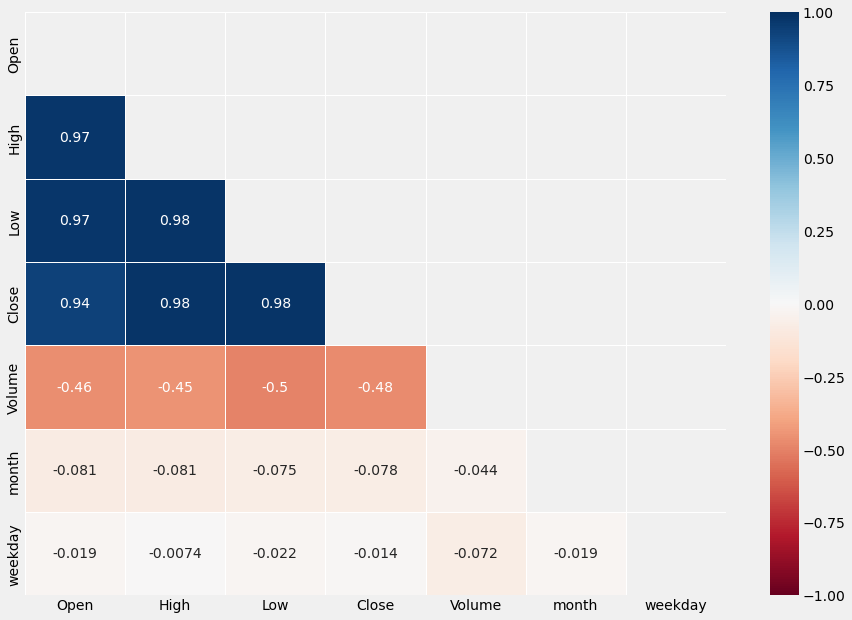

In [41]:
plt.figure(figsize=(14,10))

corr = df_stocks.iloc[:, :8].drop(["Adj Close"], axis=1).corr(method = 'spearman')
mask = np.triu(corr)
sns.heatmap(corr, square=False, mask=mask, annot = True, vmax=1, vmin=-1, linecolor="white", linewidths=0.5, cmap = "RdBu");

### Previsione

Come ultimo passo della prima parte, si cercherà di predire l'andamento del mercato, dividendo la serie storica in due con il metodo <strong>hold-out</strong>. Si valuteranno le feature più rilevanti con regolarizzazione <i>L1</i> e si confronterà l'efficacia predittiva con un modello che utilizza tutte le feature.

#### Suddivisione dei dati

Le colonne <i>"Close", "Low", "High" e "Volume"</i> non possono essere utilizzate in quanto il loro valore non è noto a inizio giornata. Pertanto, si esegue uno <i>shift</i> e slittiamo i valori in avanti di una posizione.

In [42]:
X = df_stocks.iloc[:,:-1];
X.iloc[:,1:6] = X.iloc[:,1:6].shift(1)
X.drop(columns=["Adj Close"], inplace=True)
X.dropna(inplace=True); y = df_stocks["Label"].reindex_like(X)

Nella suddivisione dei dati con il metodo hold-out, essendo una serie storica, non si effettua lo <i>shuffle</i>, poichè porterebbe a <strong>leakage</strong> dei dati, ovvero il modello impara da dati che non dovrebbero essere disponibili in uno scenario reale.

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y.reindex_like(X), shuffle=False, test_size=0.5, random_state=rnd_state)

Si considererà il periodo dal 2011-09-06 al 2014-02-04 come training set e dal 2014-02-05 al 2016-07-01 come test set.

#### Gestione delle feature

Poichè le variabili potrebbero avere domini più grandi (i.e <i>volume</i>) si effettua la <strong>normalizzazione</strong> sulle feature numeriche. Dato che le variabili numeriche non seguono una distribuzione normale, si effettua normalizzazione rispetto a standardizzazione. <br>Inoltre, si trattano le date (giorno, mese, semestre) come feature categoriche, per non dare al modello un indicazione sull'importanza dell'ordine sul processo decisionale. Pertanto, si utilizzerà <strong>One-Hot 
Encoding</strong> sulle feature categoriche.

In [44]:
numerical_features = X.iloc[:,:5].columns
categorical_features = X.iloc[:,5:].columns

Si utilizza <i>ColumnTransformer</i> con <i>remainder</i> di default <i>drop</i>: tutte le colonne <u>non</u> considerate in <i>numerical_features</i> e <i>categorical_features</i> verranno eliminate. (i.e <i>"Adj Close"</i>)

In [45]:
preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
], remainder="passthrough")

In [46]:
set_config(display='diagram')
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', MinMaxScaler(),
                                 Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['month', 'weekday', 'semes'], dtype='object'))])

In [47]:
coef_labels = list(numerical_features) + list(preprocessor.named_transformers_["cat"].get_feature_names(categorical_features))

Si salvano i nomi delle colonne in una variabile per utilizzarli successivamente come indice nel <i>DataFrame</i> dei coefficienti dei modelli.

#### Addestramento modello

Trasformate le feature e suddiviso il dataset, si addestra un semplice modello di regressione logistica con regolarizzazione <i>L1</i> per individuare le feature più rilevanti. Successivamente, si confronterà l'efficacia predittiva con un secondo modello di regressione logistica con regolarizzazione <i>L2</i> che utilizza tutte le feature.<br>

In [48]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("logit", LogisticRegression(C=10, solver="saga", penalty="l2", multi_class="multinomial", class_weight='balanced'))
])

model.fit(X_train, y_train)
model.score(X_val, y_val)

0.38879736408566723

In [49]:
model2 = Pipeline([
    ("preprocessor", preprocessor),
    ("logit", LogisticRegression(C=10, solver="saga", penalty="l1", multi_class="multinomial", class_weight="balanced")),
])

model2.fit(X_train, y_train)
model2.score(X_val, y_val)

0.3953871499176277

Sebbene l'<strong>accuracy</strong> paia essere particolarmente bassa, ottenere dei risultati nel mondo finanziario è estremamente complicato, già solo pochi punti percentuali di accuratezza rispetto a un <strong>modello casuale</strong> sarebbe un risultato particolarmente buono.

In [50]:
random_model = Pipeline([
    ("preprocessor", preprocessor),
    ("dummy", DummyClassifier(strategy="uniform", random_state=rnd_state))
])

random_model.fit(X_train, y_train)
random_model.score(X_val, y_val)

0.3443163097199341

Sembra che Il modello con regressione logistica abbia un'accuracy migliore rispetto a un modello che prende decisioni casuali. Tuttavia, questa differenza potrebbe dipendere anch'essa dal caso. Nell'ultima parte del progetto si verificherà statisticamente se la differenza tra l'efficacia predittiva del modello migliore e il modello casuale sia statisticamente significativa.<br><br>
Tramite regolarizzazione <i>L1</i> individuamo le feature più rilevanti:

In [51]:
pd.DataFrame(
    [i for i in model2.named_steps['logit'].coef_.T], 
    index=coef_labels, 
    columns=model2.named_steps['logit'].classes_)

,-1,0,1
Open,-0.298938,0.000000,0.361194
High,0.970660,-2.584969,0.000000
Low,-0.314454,3.894998,-1.127633
Close,0.000000,0.000000,0.653826
Volume,-0.313241,0.833269,0.000000
month_1,-0.083017,0.000000,0.061893
month_2,-0.062704,0.105509,0.000000
month_3,-0.212747,0.000000,0.390941
month_4,0.000000,-0.967067,0.020569
month_5,0.000019,0.000000,-0.573449


* Per i coefficienti dell'iperpiano di classe $-1$
    * $+$ <i>"High"</i>
    * $+$ <i>Agosto, Dicembre, Mercoledì</i>
    * $-$ <i>Venerdì</i>
    
<i>Mercoledì, "High"</i> e Agosto portano a una classificazione negativa.<br><br>
Si nota per la classe $-1$ scarsa rappresentatività delle feature che verrà confermata anche dalla scarsa <i>precision</i> e <i>recall</i>.

* Per i coefficienti dell'iperpiano di classe $0$,
    * $+$ <i>"Low", "Volume"</i>
    * $-$ <i>"High"</i>
    * $+$ <i>Maggio, Luglio, Novembre</i>
    * $-$ <i>Aprile, Giugno, "go away" e Martedì</i>

<i>"Low", "Volume"</i> e Novembre portano a una classificazione neutrale.<br>
<i>"High"</i>, Aprile, Giugno e Martedì <u>non</u> portano a una classificazione neutrale.
  
* Per i coefficienti dell'iperpiano di classe $1$
    * $+$ <i>"Open", "Close"</i>
    * $-$ <i>"Low", "Volume"</i>
    * $+$ <i>Marzo, Aprile, Giugno</i>
    * $-$ <i>Maggio, Agosto, Settembre, e Lunedì</i>
    
<i>"Open", "Close"</i> e Marzo, Aprile, Giugno portano a una classificazione positiva.<br>
<i>"Low", "Volume"</i>, Maggio, Agosto e <strong>Lunedì</strong> <u>non</u> portano a una classificazione positiva.

### Valutazione modelli

Per la valutazione dei modelli, si implementano le seguenti funzioni:
* <i>confidence_interval</i>, per calcolare l'intervallo di confidenza, con $\alpha$ a scelta;
* <i>eval_model</i>, per visualizzare <i>confusion matrix</i>, <i>precision</i>, <i>accuracy</i> e <i>F1-measure</i> per classe e media tra classi. Ritorna una tupla formata da <i>accuracy</i> e <i>F1-measure</i>;
* <i>eval_difference_two_model</i>, per valutare se la differenza di accuratezza tra due modelli è statisticamente significativa, con $\alpha$ a scelta.

Inoltre, si implementa <strong>un protocollo di trading</strong>, basato sull'esercitazione della borsa, ma con delle differenze:
* L'operazione di acquisto/vendita è effettuata solo se il valore predetto $\hat{y}_t$ è $1$ o $-1$
* Altrimenti, se il valore predetto $\hat{y}_t$ è $0$ non si effettua nessuna operazione.
* Nel calcolo del <i>ROI</i>, il <i>mean_open</i> è sostituito con <i>investiment</i>, ovvero il capitale investito.<br> (la somma del valore di apertura del giorno in cui si acquista o vende)

Le metriche di <i>gain</i> e <i>ROI</i> sono visualizzate all'interno di <i>eval_model</i>.

#### Protocollo di trading

In [52]:
def gain(X, y_pred):
    growth = y_pred > 0
    decline = y_pred < 0
    CO_diff = (stocks["Close"] - stocks["Open"]).reindex_like(X)
    
    return(CO_diff[growth].sum() - CO_diff[decline].sum())

def roi(X, y_pred):
    growth = y_pred > 0
    decline = y_pred < 0
    open = stocks["Open"].reindex_like(X)
    
    investiment = open[growth].sum() + open[decline].sum()
    return gain(X, y_pred) / investiment * 100

def print_eval(X, model):
    preds = model.predict(X)
    print("Gain: {:.2f}$".format(gain(X, preds)))
    print(" ROI: {:.2%}".format(roi(X, preds)))

#### Metriche

In [53]:
def confidence_interval(N, acc, alpha=0.05, verbose=False):
    if verbose:
        print(f"\n *** Calcolo intervallo di confidenza per alpha: {alpha}, N: {N} ***\n")
        
    Z = st.norm.ppf(1-alpha/2)
    denom = 2*(N+Z**2)
    p_min = (2 * N * acc + Z**2 - Z * (Z**2 + 4 * N * acc -4 * N * acc**2)**.5)/denom
    p_max = (2 * N * acc + Z**2 + Z * (Z**2 + 4 * N * acc -4 * N * acc**2)**.5)/denom
    
    return p_min, p_max

def eval_model(X, y, model, alpha=0.05, verbose=False):
    y_pred = model.predict(X)
    
    labels = ["neg", "neu", "pos"]
    metrics = ["precision", "recall", "f1_measure"]
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average=None)
    recall = recall_score(y, y_pred, average=None)
    f1_measure = f1_score(y, y_pred, average=None)
    all_classes = pd.Series([precision.mean(), recall.mean(), f1_measure.mean()],  index=metrics)
    
    if verbose:
        print("\n*** Confusion matrix ***\n")
        cf_matrix = confusion_matrix(y, y_pred)
        sns.heatmap(cf_matrix, annot=True, cmap = "Blues", fmt="d", xticklabels=labels, yticklabels=labels)
        plt.title('Confusion matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        
        print("\n*** Precision, Recall, F1-measure per classe e media ***\n")
        model_stats = pd.concat(
            [pd.DataFrame([precision, recall, f1_measure], index=metrics), all_classes], axis=1)
        model_stats.columns = labels + ["all"]
        print(model_stats)

        print("\n*** Gain, ROI ***\n")
        print_eval(X, model)

        print(f"\n*** Calcolo intervallo di confidenza con Confidenza={1-alpha} con N={X.shape[0]} per accuracy e f1-measure ***\n")
        print(f"accuracy: ({accuracy}), intervallo confidenza: {confidence_interval(X.shape[0], accuracy, alpha)}")
        print(f"f1-measure: ({f1_measure.mean()}), intervallo confidenza: {confidence_interval(X.shape[0], f1_measure.mean(), alpha)}")

    return (accuracy, f1_measure.mean(), round(roi(X, y_pred)*100, 2))
    
def eval_difference_two_model(acc1, acc2, N1, N2, alpha=0.05, confidence_level=False):
    print(f"\n*** Valutazione statistica differenza tra modello 1 e modello 2 ***")
    print(f"(acc: {acc1}, N: {N1}) (acc: {acc2}, N: {N2})\n")
    Z = st.norm.ppf(1-alpha/2)
    e1 = 1 - acc1; e2 = 1 - acc2
    d= abs(e2-e1)
    var_d = (e1*(1-e1))/N1 + (e2*(1-e2))/N2
    d_min = d - Z * var_d**0.5
    d_max = d + Z * var_d**0.5
    
    if confidence_level:
        print(f"\n*** Valutazione soglia confidenza che rende significativa la differenza tra i due modelli ***")
        print(f"a: {round(st.norm.sf(d/var_d**0.5) * 2, 2)}\n")
    
    return d_min, d_max


*** Confusion matrix ***



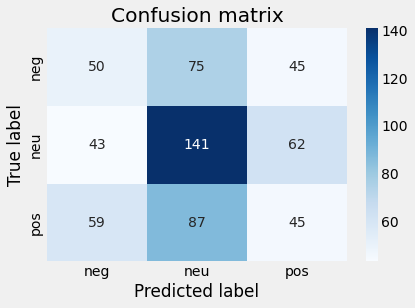


*** Precision, Recall, F1-measure per classe e media ***

                 neg       neu       pos       all
precision   0.328947  0.465347  0.296053  0.363449
recall      0.294118  0.573171  0.235602  0.367630
f1_measure  0.310559  0.513661  0.262391  0.362204

*** Gain, ROI ***

Gain: -1331.04$
 ROI: -2.55%

*** Calcolo intervallo di confidenza con Confidenza=0.95 con N=607 per accuracy e f1-measure ***

accuracy: (0.38879736408566723), intervallo confidenza: (0.35083248381848825, 0.4281609062820554)
f1-measure: (0.36220362631696945), intervallo confidenza: (0.3249448821000069, 0.4011955177769705)


In [54]:
eval_model(X_val, y_val, model, verbose=True);


*** Confusion matrix ***



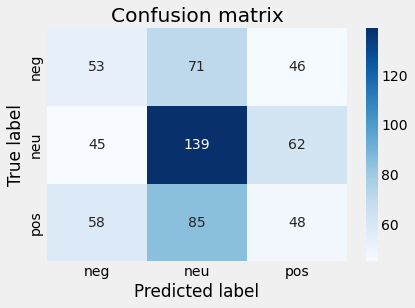


*** Precision, Recall, F1-measure per classe e media ***

                 neg       neu       pos       all
precision   0.339744  0.471186  0.307692  0.372874
recall      0.311765  0.565041  0.251309  0.376038
f1_measure  0.325153  0.513863  0.276657  0.371891

*** Gain, ROI ***

Gain: -345.08$
 ROI: -0.64%

*** Calcolo intervallo di confidenza con Confidenza=0.95 con N=607 per accuracy e f1-measure ***

accuracy: (0.3953871499176277), intervallo confidenza: (0.35726606569532116, 0.4348240123992643)
f1-measure: (0.3718912170060116), intervallo confidenza: (0.33436101199165374, 0.4110327226527487)


In [55]:
eval_model(X_val, y_val, model2, verbose=True)[1];

I due modelli di regressione logistica con regolarizzazione <i>L1, L2</i> sono pressochè simili nell'<i>accuracy, F1-measure, ROI</i>.

## 2. Introduzione di nuove feature (Sentiment Analysis)

Il dataset <i>News</i> è suddiviso in 25 colonne, dalle news giornaliere più rilevanti alle news meno rilevanti. Si hanno 1989 istanze, esattamente come i dati dell'andamento del DJIA. Si controlla se sono presenti valori <i>NaN</i> :

### Preprocessing

In [56]:
is_NaN = news.isnull()
row_has_NaN = is_NaN.any(axis=1)
col_has_NaN = is_NaN.any(axis=0)
cells_with_NaN = news.loc[row_has_NaN, col_has_NaN]

print('---------------------------------------')
print(f'  NaN: {news.isnull().sum().sum(axis=0)}')
print(f' Cols:',*news.columns[col_has_NaN == True])
print(f'Index:', *cells_with_NaN.index.date)
print('---------------------------------------')

cells_with_NaN.head()

---------------------------------------
  NaN: 7
 Cols: Top23 Top24 Top25
Index: 2009-09-15 2009-12-24 2011-04-21
---------------------------------------


,Top23,Top24,Top25
Date,,,
2009-09-15,NaN,NaN,NaN
2009-12-24,"b""Ayatollah Montazeri's Legacy: In death he m...",NaN,NaN
2011-04-21,Prince Charles wins some kind of a record,NaN,NaN


Si hanno solo 7 <i>NaN</i>, per cui piuttosto che rimuovere le righe corrispondenti, si andrà a riempire le celle con stringhe vuote ("").

In [57]:
# inplace=True for slice of a dataframe won't work. It works on complete dataframe.
news.loc[row_has_NaN, col_has_NaN] = news.loc[row_has_NaN, col_has_NaN].fillna("", inplace=False)

print('---------------------------------------')
print(f'  NaN: {news.isnull().sum().sum(axis=0)}')
print('---------------------------------------')

---------------------------------------
  NaN: 0
---------------------------------------


In [58]:
print('---------------------------------------')
print(f"shape news: {news.shape[0]}, shape label: {label.shape[0]}")
print('---------------------------------------')

---------------------------------------
shape news: 1989, shape label: 1989
---------------------------------------


Si utilizza <i>multiindex</i> per trasformare il dataset: per ogni giorno le 25 celle delle 25 colonne diventano istanze. 

* Da 1989 istanze e 25 colonne, si ottiene un'unica colonna con 49725 istanze. 
* Ad ogni istanza giornaliera corrisponde l'etichetta giornaliera (1,0).<br> 


Così facendo, si riesce a stimare indipendentemente l'opinione positiva o negativa di ogni news. <br> 
<hr>L'<strong>obiettivo</strong> è di ottenere un modello di learning che predice positivo (1) o negativo (0) per ogni news. Successivamente, si andrà a raggruppare l'insieme di previsioni positive o negative in un'unica colonna, contenente per ogni giorno un'etichetta positiva o negativa che descrive se l'insieme di notizie sono più positive o negative.
<hr>

In [59]:
df_news = pd.DataFrame(news.drop(["Label"], axis=1).stack()).join(news["Label"]).rename(columns={0:"Text"})

Si pulisce ogni news da <u>caratteri speciali</u> o <u>caratteri non voluti</u> con una funzione <i>clean</i> :

In [60]:
filters = [ 'b"', 'b\'', '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', 
            '.', '/',  '\\', ':', ';', '<', '=', '>', '?', '@', '[', ']', '^', 
            '_', '`', '{', '|', '}', '\t', '\n', ",", '~' , '—', '\'', '\\' ]

def clean(text):
    clean_text = text
    for filter in filters:
        clean_text = clean_text.replace(filter, '').strip()
    return clean_text;

In [61]:
df_news["Text"] = df_news["Text"].map(clean)

In [62]:
df_news.sample(10)

,,Text,Label
Date,,,
2012-12-14,Top6,Computer hacker Gary McKinnon who is wanted in...,0
2010-06-02,Top17,Israel will respond in like with the same comm...,1
2015-06-19,Top4,A Gold Coast police officer who leaked video f...,0
2008-12-30,Top23,Israel If this is how the Children of God act ...,1
2010-09-30,Top25,German Conservative Parties Agree To End Consc...,0
2015-09-08,Top7,A former Dragons Den star has been charged wit...,1
2014-09-08,Top23,Norwegian MP says Norway should arrest Snowden...,0
2014-05-16,Top2,Villagers Kill 200 Boko Haram Insurgents With ...,1
2012-12-17,Top7,Health Canada Plans to Treat Marijuana Like Ot...,1


### Vader

Inizialmente, si usa <strong>VADER</strong> (Valence Aware Dictionary and sEntiment Reasoner), un modello preaddestrato; VADER si basa su un insieme di regole e su un dizionario (<i>lexicon</i>), che associa ad ogni parola un punteggio che ne denota la valenza positiva o negativa.

In [63]:
vader = SentimentIntensityAnalyzer()

In [64]:
def label_review(review):
    sentences = nltk.sent_tokenize(review)
    scores = list(map(vader.polarity_scores, sentences))
    return 1 if sum(s["compound"] for s in scores) >= 0 else 0

In [65]:
df_news["vader_preds"] = [label_review(news) for news in df_news["Text"]];

In [66]:
round(df_news.groupby("Date").sum()/25).head(5)

,Label,vader_preds
Date,,
2008-08-08,0.0,0.0
2008-08-11,1.0,0.0
2008-08-12,0.0,1.0
2008-08-13,0.0,0.0
2008-08-14,1.0,0.0


In [67]:
accuracy_score(round(df_news.groupby("Date").sum()["vader_preds"]/25), news["Label"])

0.49824032176973354

VADER, essendo un approccio basato sul <i>lexicon</i>, è limitato dalla grandezza del <i>lexicon</i> e può non catturare delle parole non presenti o non dare il giusto peso a parole importanti per il nostro caso d'uso. Inoltre, un approccio basato sul <i>lexicon</i> non cattura le negazioni come <strong>not bad</strong>, dove altri tipi di approccio con i <i>bi-gram</i> possono catturarle. Per questi motivi, è giustificabile la scarsa accuratezza di VADER.

### Tf-idf

Il secondo approccio, `TfidfVectorizer`, è un filtro utilizzabile per estrarre matrici documenti-termini. Successivamente, si addestra un modello di classificazione su tale matrice per stimare l'orientamento delle news.

In [68]:
df_news.loc[ X_train[0:].index[0]:X_train.iloc[-1:].index[0]]

Text  Label  \
Date                                                                         
2011-09-06 Top1            Turkish PM suspends all ties with Israel      0   
           Top2   Nigeria shifting currency reserves from US dol...      0   
           Top3   Swiss National Bank says it will buy all other...      0   
           Top4   Indian politicianyes statuesandal jet lady cal...      0   
           Top5   China is acquiring the means to win without fi...      0   
...                                                             ...    ...   
2014-02-04 Top21  Russian dad talks killer son into freeing clas...      1   
           Top22  Pakistan Has A Months Worth Of Water Left and ...      1   
           Top23  Germany wants Britain to stay in EU because it...      1   
           Top24  NSA Scandal Boosts German Tech Industry The Ge...      1   
           Top25  Oneyear prison sentence for 21yearold Twitter ...      1   

                  vader_preds  
Date                           
2011-09-06 Top1             1  
           Top2             1  
           Top3             0  
           Top4             0  
           Top5             1  
...                       ...  
2014-02-04 Top21            0  
           Top22            1  
           Top23            0  
           Top24            1  
           Top25            0  

[15175 rows x 3 columns]

In [69]:
try:
    df_news.drop(["vader_preds"], axis=1, inplace=True)
    df_news.drop(["tfidf_preds"], axis=1, inplace=True)
except:
    print(f"Già cancellate le colonne 'vader_preds', 'tfidf_preds'")
    
y_train_nlp = df_news.loc[X_train[0:].index[0]:X_train.iloc[-1:].index[0]]["Label"]; 
X_train_nlp = np.array(df_news.loc[ X_train[0:].index[0]:X_train.iloc[-1:].index[0]].drop(["Label"], axis=1)).reshape(-1)
y_val_nlp = df_news.loc[X_val[0:].index[0]:X_val.iloc[-1:].index[0]]["Label"]; 
X_val_nlp = np.array(df_news.loc[X_val[0:].index[0]:X_val.iloc[-1:].index[0]].drop(["Label"], axis=1)).reshape(-1)

Già cancellate le colonne 'vader_preds', 'tfidf_preds'


`TfidfVectorizer` usa un algoritmo semplice per scomporre le parole nei documenti. Si utilizzerà una funzione alternativa, che oltre a scomporre le parole nei documenti, effettuerà la <strong>lemmatizzazione</strong> e rimuovere le <i>stopwords</i>.

In [70]:
penn_to_wn = {"N": "n", "V": "v", "J": "a", "R": "r"}
def tokenize_with_lemmatization_and_stoplist(text):
    return [(wnl.lemmatize(token, penn_to_wn[tag[0]]) if tag[0] in penn_to_wn else token)
            for token, tag in nltk.pos_tag(nltk.tokenize.word_tokenize(text)) if token not in stoplist]

Si utilizza <i>RandomizedSearchCv</i> per cercare gli iperparametri migliori da utilizzare nel successivo <i>TextTransformer</i> per generare la colonna di aggregazione delle news predette come positive o negative.

In [71]:
nlp_model = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("classifier", LogisticRegression(solver="saga"))
])

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=rnd_state)

grid = {
    'vectorizer__min_df' : [1, 3, 5],
    'vectorizer__tokenizer': [None, tokenize_with_lemmatization_and_stoplist],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
}

gs = RandomizedSearchCV(nlp_model, grid, cv=skf, scoring=make_scorer(f1_score , average='weighted'), n_jobs=-1, 
                        random_state=rnd_state, n_iter=10)

gs.fit(X_train_nlp, y_train_nlp)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                             ('classifier',
                                              LogisticRegression(solver='saga'))]),
                   n_jobs=-1,
                   param_distributions={'classifier__C': [0.1, 1, 10],
                                        'classifier__penalty': ['l1', 'l2'],
                                        'vectorizer__min_df': [1, 3, 5],
                                        'vectorizer__ngram_range': [(1, 1),
                                                                    (1, 2)],
                                        'vectorizer__tokenizer': [None,
                                                                  <function tokenize_with_lemmatization_and_stoplist at 0x7f9d899f7dc0>]},
                   random_state=42,
                   scoring=make_scorer(f1_score, average=weighted))

In [72]:
gs.best_params_

{'vectorizer__tokenizer': None,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__min_df': 1,
 'classifier__penalty': 'l2',
 'classifier__C': 10}

In [73]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vectorizer__tokenizer,param_vectorizer__ngram_range,param_vectorizer__min_df,param_classifier__penalty,param_classifier__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.304622,0.013259,0.087025,0.001985,None,"(1, 1)",3,l1,0.1,"{'vectorizer__tokenizer': None, 'vectorizer__n...",0.367808,0.367702,0.367702,0.367737,0.000050,8
1,1.897329,0.072376,0.135573,0.006148,None,"(1, 2)",1,l2,10,"{'vectorizer__tokenizer': None, 'vectorizer__n...",0.519359,0.511784,0.516430,0.515858,0.003119,1
2,0.724868,0.002244,0.176517,0.004455,None,"(1, 2)",3,l2,0.1,"{'vectorizer__tokenizer': None, 'vectorizer__n...",0.408088,0.401240,0.403993,0.404440,0.002813,7
3,0.352488,0.008412,0.096107,0.003459,None,"(1, 1)",1,l1,0.1,"{'vectorizer__tokenizer': None, 'vectorizer__n...",0.367808,0.367702,0.367702,0.367737,0.000050,8
4,1.196314,0.096411,0.096647,0.005161,None,"(1, 1)",3,l1,1,"{'vectorizer__tokenizer': None, 'vectorizer__n...",0.492634,0.491346,0.500140,0.494707,0.003878,4
5,52.174613,0.079888,0.102474,0.006182,None,"(1, 2)",1,l1,10,"{'vectorizer__tokenizer': None, 'vectorizer__n...",0.514144,0.510537,0.510950,0.511877,0.001612,3
6,0.585353,0.005497,0.169751,0.000421,None,"(1, 2)",5,l1,0.1,"{'vectorizer__tokenizer': None, 'vectorizer__n...",0.367808,0.367702,0.367702,0.367737,0.000050,8
7,1.715041,0.140097,0.097195,0.001983,None,"(1, 2)",5,l1,1,"{'vectorizer__tokenizer': None, 'vectorizer__n...",0.491451,0.485142,0.492654,0.489749,0.003295,5
8,0.408445,0.013979,0.101719,0.002199,None,"(1, 1)",1,l2,0.1,"{'vectorizer__tokenizer': None, 'vectorizer__n...",0.415601,0.404778,0.417305,0.412561,0.005548,6
9,28.427526,0.130531,0.095971,0.001839,None,"(1, 2)",3,l1,10,"{'vectorizer__tokenizer': None, 'vectorizer__n...",0.515959,0.500936,0.518747,0.511881,0.007822,2


In [74]:
df_news_X = df_news.loc[ X_train[0:].index[0]:X_train.iloc[-1:].index[0]]

In [75]:
df_news_X["tfidf_preds"] = gs.predict(X_train_nlp)

In [76]:
df_news_X.sample(5)

,,Text,Label,tfidf_preds
Date,,,,
2012-03-26,Top8,Israel cuts ties with UN human rights body Mi...,1,1
2012-02-16,Top24,Facing backlash Canada Conservatives eye rewri...,1,1
2011-11-07,Top21,European leaders are hoping China will be a ma...,1,1
2013-07-08,Top17,Canadians continue to trade fundamental freedo...,1,1
2013-03-26,Top23,Spanish Government Bows Down To US Pressures A...,1,1


In [77]:
accuracy_score(round(df_news_X.groupby("Date").sum()["tfidf_preds"]/25), news["Label"].reindex_like(X_train))

1.0

In [78]:
gs.score(X_val_nlp, y_val_nlp)

0.5011696577155446

Si definisce la funzione <strong>wordcloud</strong> per rappresentare in maniera grafica l'importanza o la frequenza di dati testuali. Più precisamente, la grandezza della parola indica quanto quella parola contribuisca a rendere una news positiva o negativa.

In [79]:
def wordcloud(word_significance, title=None, max_words=100, stopwords=None):
    
    wc = WordCloud(width=800, 
                   height=400, 
                   background_color="black", 
                   colormap="Paired",
                   max_font_size=150, 
                   max_words=max_words)
        
    wc.generate_from_frequencies(word_significance)
    
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [80]:
coefs = pd.Series(gs.best_estimator_.named_steps['classifier'].coef_[0], 
                  index=gs.best_estimator_.named_steps['vectorizer'].get_feature_names())

coefs.sort_values(inplace=True)

Utilizzando la funzione appena descritta, si vede che molte parole negative hanno un significato <strong>geopolitico</strong>, spesso nominando paesi problematici con conflitti in corso. (<i>israel, taliban, russia, ukrain, syrian...</i>) Altre parole hanno invece un significato <strong>forte</strong>. (<i>killed by, to ban, war with, scandal, hacking...</i>) Perciò notizie su manifestazioni, proteste, conflitti e guerre vengono classificate dal modello come 0.

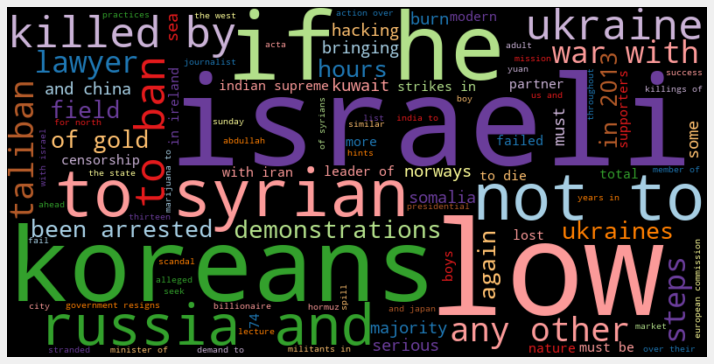

In [81]:
wordcloud(abs(coefs[coefs < 0]))

Discorso diverso invece per le parole positive, si vede infatti come la maggior parte delle parole hanno poca significatività e risultano piuttosto blande. Una possibile spiegazione è che il modello interpreta la <strong>non notizia</strong> come <u>notizia positiva</u>.

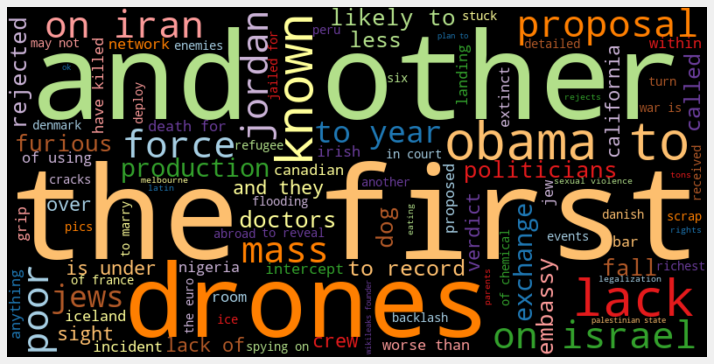

In [82]:
wordcloud(coefs[coefs > 0])

Infine, si definisce il `TextTransformer`, che dall'insieme di notizie giornaliere genera una colonna, dove ogni istanza è l'<strong>aggregazione</strong> giornaliera di classificazioni positive o negative. Se il numero di notizie classificate positive è maggiore delle negative, allora l'aggregazione è positiva, altrimenti negativa.

In [83]:
class TextTransformer(BaseEstimator, TransformerMixin):
    """This class will perform the sentiment daily prediction."""
    
    def __init__(self):
        self.nlp_model = Pipeline([
            ("vectorizer", TfidfVectorizer(min_df=1, ngram_range=(1,2))),
            ("classifier", LogisticRegression(solver="saga", C=10, penalty='l2'))
        ])
        
    def fit(self, X, y=None):
        X_copy =\
        pd.DataFrame(X.drop(["Label"], axis=1).stack())\
        .reset_index().drop("level_1", axis=1).rename(columns={"level_0":"Date"}).set_index("Date")\
        .join(X["Label"]).rename(columns={0:"Text"})
        
        X_copy["Text"] = X_copy["Text"].map(clean)
        
        self.nlp_model.fit(X_copy["Text"], X_copy["Label"])
        
        return self

    def transform(self, X, y=None):
        X_copy =\
        pd.DataFrame(X.drop(["Label"], axis=1).stack())\
        .reset_index().drop("level_1", axis=1).rename(columns={"level_0":"Date"}).set_index("Date")\
        .rename(columns={0:"Text"})

        X_copy["Text"] = X_copy["Text"].map(clean)

        X_copy["preds"] = self.nlp_model.predict(X_copy["Text"])

        return pd.DataFrame(round(X_copy.groupby(X_copy.index).sum()["preds"]/25))

## Generazione dei modelli

In [84]:
label.value_counts()

0     852
1     626
-1    511
Name: Label, dtype: int64

Prima della generazione di diversi modelli di learning si uniscono le feature numeriche e categoriche con anche dati non strutturati delle news. Si aggiunge pertanto, `TextTransformer` al `ColumnTransformer` per preprocessare le news e avere infine, un'unica matrice su cui addestrare i modelli di learning.

In [85]:
X_tss = pd.concat([X, news.reindex(X.index)], axis=1)
text_features = X_tss.iloc[:,8:].columns

In [86]:
preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("text", TextTransformer(), text_features)
], remainder="passthrough")

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', MinMaxScaler(),
                                 Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['month', 'weekday', 'semes'], dtype='object')),
                                ('text', TextTransformer(),
                                 Index(['Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8',
       'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16',
       'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24',
       'Top25'],
      dtype='object'))])

In [87]:
if "Sentiment" not in coef_labels:
    coef_labels += ["Sentiment"]
else:
    print("Label 'Sentiment' Già presente")

In [88]:
X_tss_train, X_tss_test, y_tss_train, y_tss_test = train_test_split(X_tss, y, shuffle=False, test_size=0.3, random_state=rnd_state)

L'ottimizzazione degli iperparametri con cross validation a *k* fold non è possibile per le serie storiche, infatti scegliere campioni casuali e assegnarli al <i>train set</i> o <i>test set</i> non avrebbe senso, sarebbe come utilizzare valori futuri, che non sarebbero conosciuti nella realtà, per predire valori passati.<br>Come soluzione, scikit-learn mette a disposizione il `TimeSeriesSplit(k)`, dove il dataset viene diviso in <i>k+1</i> fold contigui di pari dimensioni ed ogni split <i>i</i> da 1 a <i>k</i> contiene i primi <i>i</i> fold come training set e il <i>i+1-esimo</i> come validation set.

In [89]:
tss = TimeSeriesSplit(3)

for i, (train, val) in enumerate(tss.split(X_tss_train), start=1):
    print("FOLD {}".format(i))
    train_dates = X_tss_train.index[train]
    val_dates = X_tss_train.index[val]
    print("Training set da {} a {}".format(train_dates.min(), train_dates.max()))
    print("Validation set da {} a {}".format(val_dates.min(), val_dates.max()))

FOLD 1
Training set da 2011-09-06 00:00:00 a 2012-07-10 00:00:00
Validation set da 2012-07-11 00:00:00 a 2013-05-15 00:00:00
FOLD 2
Training set da 2011-09-06 00:00:00 a 2013-05-15 00:00:00
Validation set da 2013-05-16 00:00:00 a 2014-03-19 00:00:00
FOLD 3
Training set da 2011-09-06 00:00:00 a 2014-03-19 00:00:00
Validation set da 2014-03-20 00:00:00 a 2015-01-21 00:00:00


### Modelli di learning

Per ogni algoritmo visto a lezione, si ricerca il modello ottimale impiegando `grid search` con `TimeSeriesSplit(k)` su <i>x_tss_train</i>, in seguito si valida il modello a regime su <i>x_tss_val</i>.

#### Regressione Logistica

In [90]:
logit_model = Pipeline([
    ("preprocessor", preprocessor),
    ("logit", LogisticRegression(solver="saga"))
])

logit_grid = [
    
    # spazio di ricerca
    
#     {
#         "logit__penalty" : [None],
#         "logit__class_weight": [None, "balanced"]
#     },
#     {
#         "logit__penalty" : ["l1", "l2"],
#         "logit__C" :  np.logspace(-5, 3, 9),
#         "logit__class_weight": [None, "balanced"]
#     },
#     {
#         "logit__penalty" : ["elasticnet"],
#         "logit__l1_ratio" : [0.25, 0.5, 0.75],
#         "logit__C" :  np.logspace(-5, 3, 9),
#         "logit__class_weight": [None, "balanced"]
#     }
    
    # iperparametri trovati
    {
        "logit__penalty" : ["l1"],
        "logit__C" :  [10],
        "logit__class_weight": [None] 
    }
]

logit_gs = GridSearchCV(logit_model, logit_grid, cv=tss, scoring=make_scorer(f1_score, average="weighted"),
                        n_jobs=-1, refit=True)
logit_gs.fit(X_tss_train, y_tss_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['month', 'weekday', 'semes'], dty...
                                                                         Index(['Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8',
       'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16',
       'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24',
       'Top25'],
      dtype='object'))])),
                                       ('logit',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid=[{'logit__C': [10], 'logit__class_weight': [None],
                          'logit__penalty': ['l1']}],
             scoring=make_scorer(f1_score, average=weighted))

In [91]:
logit_gs.best_params_

{'logit__C': 10, 'logit__class_weight': None, 'logit__penalty': 'l1'}


*** Confusion matrix ***



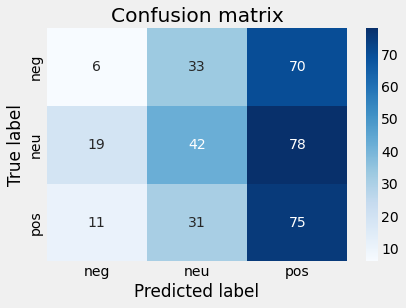


*** Precision, Recall, F1-measure per classe e media ***

                 neg       neu       pos       all
precision   0.166667  0.396226  0.336323  0.299739
recall      0.055046  0.302158  0.641026  0.332743
f1_measure  0.082759  0.342857  0.441176  0.288931

*** Gain, ROI ***

Gain: 230.25$
 ROI: 0.51%

*** Calcolo intervallo di confidenza con Confidenza=0.95 con N=365 per accuracy e f1-measure ***

accuracy: (0.336986301369863), intervallo confidenza: (0.2904155098636802, 0.3869526461443737)
f1-measure: (0.2889307447116778), intervallo confidenza: (0.24481942981757493, 0.33743860361196204)


In [92]:
logit_acc, logit_f1, logit_roi = eval_model(X_tss_test, y_tss_test, logit_gs, verbose=True)
logit_stats = [logit_acc, logit_f1, logit_roi]

#### SVM

Rispetto alla `regressione logistica` o il `perceptron`, che trovano un iperpiano di separazione lineare, i seguenti algoritmi sono modelli <strong>non lineari</strong>, che o <u>mappano lo spazio in un numero maggiore di dimensioni</u> (<i>SVM, Multi-layer Perceptron</i>) per trovare un iperpiano di separazione, o <u>suddividono lo spazio</u> ricorsivamente (<i>Decision Tree, Random Forest, XGBoost</i>) per trovare una soluzione ottimale.

Lo spazio di ricerca del modello ottimo con kernel <i>RBF</i> è bidimensionale, le curve di livello sono combinazioni di `gamma` e `C` che producono soluzioni equivalenti. Perciò si fissa un iperparametro, in questo caso `C` e si ottimizza l'altro iperparametro `gamma`.

In [93]:
svm_model = Pipeline([
    ("preprocessor", preprocessor),
    ("svc", SVC())
])

svm_grid = [
    
    # spazio di ricerca
    
#     {
#         "svc__kernel" : ["poly"],
#         "svc__degree" : np.arange(2, 11, 1),
#         "svc__C" : np.logspace(-5, 3, 9),
#         "svc__class_weight": [None, "balanced"]
#     },
#     {
#         "svc__kernel" : ["rbf"],
#         "svc__gamma" : np.logspace(-5, 3, 9),
#         "svc__class_weight": [None, "balanced"]
#     }

    # iperparametri trovati
    {
        "svc__kernel" : ["poly"],
        "svc__degree" : [8],
        "svc__C" : [0.01],
        "svc__class_weight": [None] 
    }
]

svm_gs = GridSearchCV(svm_model, svm_grid, cv=tss, scoring=make_scorer(f1_score, average="weighted"), 
                      n_jobs=-1, refit=True)
svm_gs.fit(X_tss_train, y_tss_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['month', 'weekday', 'semes'], dty...
                                                                         Index(['Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8',
       'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16',
       'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24',
       'Top25'],
      dtype='object'))])),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid=[{'svc__C': [0.01], 'svc__class_weight': [None],
                          'svc__degree': [8], 'svc__kernel': ['poly']}],
             scoring=make_scorer(f1_score, average=weighted))

In [94]:
# pd.DataFrame(svm_gs.cv_results_).sort_values(by="mean_test_score", ascending=False).iloc[:5,:]

In [95]:
svm_gs.best_params_

{'svc__C': 0.01,
 'svc__class_weight': None,
 'svc__degree': 8,
 'svc__kernel': 'poly'}


*** Confusion matrix ***



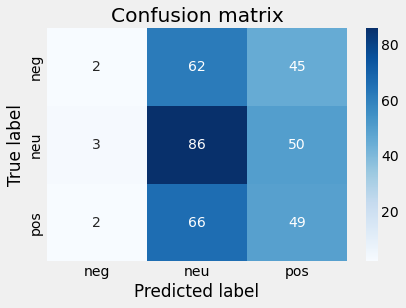


*** Precision, Recall, F1-measure per classe e media ***

                 neg       neu       pos       all
precision   0.285714  0.401869  0.340278  0.342620
recall      0.018349  0.618705  0.418803  0.351952
f1_measure  0.034483  0.487252  0.375479  0.299071

*** Gain, ROI ***

Gain: -136.51$
 ROI: -0.51%

*** Calcolo intervallo di confidenza con Confidenza=0.95 con N=365 per accuracy e f1-measure ***

accuracy: (0.37534246575342467), intervallo confidenza: (0.3272082275989834, 0.426073303465999)
f1-measure: (0.29907127015654905), intervallo confidenza: (0.25439174782814444, 0.3479361107192751)


In [96]:
svm_acc, svm_f1, svm_roi = eval_model(X_tss_test, y_tss_test, svm_gs, verbose=True)
svm_stats = [svm_acc, svm_f1, svm_roi]

#### Alberi decisionali

In [97]:
tree_model = Pipeline([
    ("preprocessor", preprocessor),
    ("tree", DecisionTreeClassifier(random_state=rnd_state))
])

tree_grid = [
    {
        # spazio di ricerca
        
#         "tree__max_depth" : [5, 10, 15, 20],
#         "tree__min_samples_leaf": [1, 5, 10, 15],
#         "tree__min_samples_split": [2, 5, 10, 20],
#         "tree__criterion": ['gini', 'entropy'],
#         "tree__class_weight": [None, "balanced"]
        
        # iperparametri trovati
        
        "tree__max_depth" : [10],
        "tree__min_samples_leaf": [1],
        "tree__min_samples_split": [2],
        "tree__criterion": ['gini'],
        "tree__class_weight": ["balanced"]
    }
]

tree_gs = GridSearchCV(tree_model, tree_grid, cv=tss, scoring=make_scorer(f1_score, average="weighted"), 
                       n_jobs=-1, refit=True)
tree_gs.fit(X_tss_train, y_tss_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['month', 'weekday', 'semes'], dty...
       'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24',
       'Top25'],
      dtype='object'))])),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'tree__class_weight': ['balanced'],
                          'tree__criterion': ['gini'], 'tree__max_depth': [10],
                          'tree__min_samples_leaf': [1],
                          'tree__min_samples_split': [2]}],
             scoring=make_scorer(f1_score, average=weighted))

In [98]:
# pd.DataFrame(tree_gs.cv_results_).sort_values(by="mean_test_score", ascending=False).iloc[:5,:]

In [99]:
tree_gs.best_params_

{'tree__class_weight': 'balanced',
 'tree__criterion': 'gini',
 'tree__max_depth': 10,
 'tree__min_samples_leaf': 1,
 'tree__min_samples_split': 2}


*** Confusion matrix ***



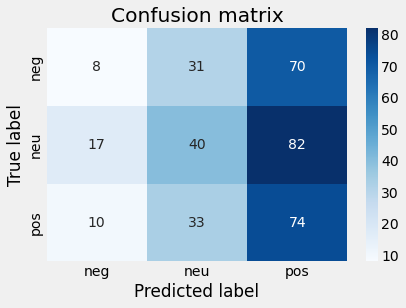


*** Precision, Recall, F1-measure per classe e media ***

                 neg       neu       pos       all
precision   0.228571  0.384615  0.327434  0.313540
recall      0.073394  0.287770  0.632479  0.331214
f1_measure  0.111111  0.329218  0.431487  0.290605

*** Gain, ROI ***

Gain: -373.32$
 ROI: -0.82%

*** Calcolo intervallo di confidenza con Confidenza=0.95 con N=365 per accuracy e f1-measure ***

accuracy: (0.33424657534246577), intervallo confidenza: (0.28780057747500953, 0.3841451946004066)
f1-measure: (0.29060536619115607), intervallo confidenza: (0.24639832368595252, 0.33917407056388865)


In [100]:
tree_acc, tree_f1, tree_roi = eval_model(X_tss_test, y_tss_test, tree_gs, verbose=True)
tree_stats = [tree_acc, tree_f1, tree_roi]

#### Random Forest

In [101]:
forest_model = Pipeline([
    ("preprocessor", preprocessor),
    ("forest", RandomForestClassifier(bootstrap=False, random_state=rnd_state))
])

forest_grid = [
    {
        # spazio di ricerca
        
#         "forest__n_estimators": [100, 250, 500],
#         "forest__max_depth" : [5, 10, 15, 20],
#         "forest__min_samples_leaf": [1, 5, 10, 15],
#         "forest__min_samples_split": [2, 5, 10, 20],
#         "forest__criterion": ['gini', 'entropy'],
#         "forest__class_weight": [None, "balanced_subsample"]
        
        # iperparametri trovati
        
        "forest__n_estimators": [100],
        "forest__max_depth" : [20],
        "forest__min_samples_leaf": [1],
        "forest__min_samples_split": [5],
        "forest__criterion": ['entropy'],
        "forest__class_weight": ["balanced_subsample"],
    }
]

forest_gs = GridSearchCV(forest_model, forest_grid, cv=tss, scoring=make_scorer(f1_score , average='weighted'),
                         n_jobs=-1, refit=True)
forest_gs.fit(X_tss_train, y_tss_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['month', 'weekday', 'semes'], dty...
      dtype='object'))])),
                                       ('forest',
                                        RandomForestClassifier(bootstrap=False,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid=[{'forest__class_weight': ['balanced_subsample'],
                          'forest__criterion': ['entropy'],
                          'forest__max_depth': [20],
                          'forest__min_samples_leaf': [1],
                          'forest__min_samples_split': [5],
                          'forest__n_estimators': [100]}],
             scoring=make_scorer(f1_score, average=weighted))

In [102]:
# pd.DataFrame(forest_gs.cv_results_).sort_values(by="mean_test_score", ascending=False).iloc[:5,:]

In [103]:
forest_gs.best_params_

{'forest__class_weight': 'balanced_subsample',
 'forest__criterion': 'entropy',
 'forest__max_depth': 20,
 'forest__min_samples_leaf': 1,
 'forest__min_samples_split': 5,
 'forest__n_estimators': 100}


*** Confusion matrix ***



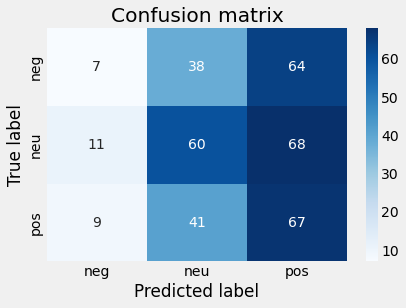


*** Precision, Recall, F1-measure per classe e media ***

                 neg       neu       pos       all
precision   0.259259  0.431655  0.336683  0.342532
recall      0.064220  0.431655  0.572650  0.356175
f1_measure  0.102941  0.431655  0.424051  0.319549

*** Gain, ROI ***

Gain: -330.33$
 ROI: -0.84%

*** Calcolo intervallo di confidenza con Confidenza=0.95 con N=365 per accuracy e f1-measure ***

accuracy: (0.36712328767123287), intervallo confidenza: (0.319295809698524, 0.41771856956854514)
f1-measure: (0.3195488285469911), intervallo confidenza: (0.2738033517073192, 0.36905307885263466)


In [104]:
forest_acc, forest_f1, forest_roi = eval_model(X_tss_test, y_tss_test, forest_gs, verbose=True)
forest_stats = [forest_acc, forest_f1, forest_roi]

#### XGBoost

In [105]:
xgb_model = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", XGBClassifier(
                          tree_method='gpu_hist', predictor='gpu_predictor', 
                          objective="multi:softmax",
                          eval_metric="merror",
                          random_state=rnd_state ))
])

xgb_grid = [
    {
        # spazio di ricerca
        
#         'xgb__min_child_weight': [5, 10],
#         'xgb__subsample': [0.5, 0.6],
#         'xgb__colsample_bytree': [0.1, 0.5],
#         'xgb__reg_alpha': [0.5],
#         'xgb__reg_lambda': [0.5],
#         'xgb__n_estimators': [10, 100],
#         'xgb__max_depth': [2, 10],
#         'xgb__learning_rate': [0.01, 0.1]
        
        # iperparametri trovati
        
        'xgb__min_child_weight': [5],
        'xgb__subsample': [0.5],
        'xgb__colsample_bytree': [0.5],
        'xgb__reg_alpha': [0.5],
        'xgb__reg_lambda': [0.5],
        'xgb__n_estimators': [100],
        'xgb__max_depth': [2],
        'xgb__learning_rate': [0.01]
    } 
]

xgb_gs = GridSearchCV(xgb_model, xgb_grid, cv=tss, scoring=make_scorer(f1_score , average='weighted'), 
                      n_jobs=-1, refit=True)
xgb_gs.fit(X_tss_train, y_tss_train)

/home/alessoarcara/miniconda3/envs/rapids-21.08/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/alessoarcara/miniconda3/envs/rapids-21.08/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/alessoarcara/miniconda3/envs/rapids-21.08/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/alessoa

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['month', 'weekday', 'semes'], dty...
                                                      subsample=None,
                                                      tree_method='gpu_hist',
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             n_jobs=-1,
             param_grid=[{'xgb__colsample_bytree': [0.5],
                          'xgb__learning_rate': [0.01], 'xgb__max_depth': [2],
                          'xgb__min_child_weight': [5],
                          'xgb__n_estimators': [100], 'xgb__reg_alpha': [0.5],
                          'xgb__reg_lambda': [0.5], 'xgb__subsample': [0.5]}],
             scoring=make_scorer(f1_score, average=weighted))

In [106]:
# pd.DataFrame(xgb_gs.cv_results_).sort_values(by="mean_test_score", ascending=False).iloc[:5,:]

In [107]:
xgb_gs.best_params_

{'xgb__colsample_bytree': 0.5,
 'xgb__learning_rate': 0.01,
 'xgb__max_depth': 2,
 'xgb__min_child_weight': 5,
 'xgb__n_estimators': 100,
 'xgb__reg_alpha': 0.5,
 'xgb__reg_lambda': 0.5,
 'xgb__subsample': 0.5}


*** Confusion matrix ***



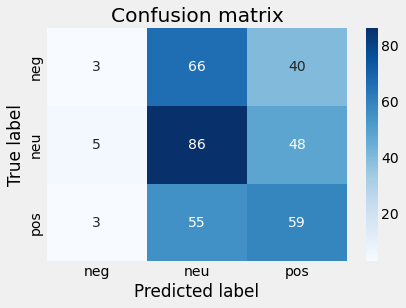


*** Precision, Recall, F1-measure per classe e media ***

                 neg       neu       pos       all
precision   0.272727  0.415459  0.401361  0.363182
recall      0.027523  0.618705  0.504274  0.383500
f1_measure  0.050000  0.497110  0.446970  0.331360

*** Gain, ROI ***

Gain: 3255.46$
 ROI: 12.05%

*** Calcolo intervallo di confidenza con Confidenza=0.95 con N=365 per accuracy e f1-measure ***

accuracy: (0.4054794520547945), intervallo confidenza: (0.3563474750001277, 0.45658027932386996)
f1-measure: (0.33135984118643075), intervallo confidenza: (0.2850472828803725, 0.3811851511645431)


In [108]:
xgb_acc, xgb_f1, xgb_roi = eval_model(X_tss_test, y_tss_test, xgb_gs, verbose=True)
xgb_stats = [xgb_acc, xgb_f1, xgb_roi]

#### Multi-layer Perceptron

In [109]:
mlp_model = Pipeline([
    ("preprocessor", preprocessor),
    ("mlp", MLPClassifier(activation='relu', shuffle=False, random_state=rnd_state))
])

# hidden_layer_sizes = [(32, 16, 8),
#                       (64, 32, 16, 8),
#                       (128, 64, 32, 16, 8),
#                       (256, 128, 64, 32, 16, 8),
#                       (512, 256, 128, 64, 32, 16, 8)]

mlp_grid = [
    {
        # spazio di ricerca

#         'mlp__solver': ['adam'],
#         'mlp__early_stopping': [False],https://www.google.com/search?channel=fs&client=ubuntu&q=andea
#         'mlp__hidden_layer_sizes': hidden_layer_sizes
        
        # iperparametri trovati
        
        'mlp__solver': ['adam'],
        'mlp__hidden_layer_sizes': [(512, 256, 128, 64, 32, 16, 8)]
    }
]

mlp_gs = GridSearchCV(mlp_model, mlp_grid, cv=tss, scoring=make_scorer(f1_score , average='weighted'), 
                      n_jobs=-1, refit=True)
mlp_gs.fit(X_tss_train, y_tss_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['month', 'weekday', 'semes'], dty...
       'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16',
       'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24',
       'Top25'],
      dtype='object'))])),
                                       ('mlp',
                                        MLPClassifier(random_state=42,
                                                      shuffle=False))]),
             n_jobs=-1,
             param_grid=[{'mlp__hidden_layer_sizes': [(512, 256, 128, 64, 32,
                                                       16, 8)],
                          'mlp__solver': ['adam']}],
             scoring=make_scorer(f1_score, average=weighted))

In [110]:
# pd.DataFrame(mlp_gs.cv_results_).sort_values(by="mean_test_score", ascending=False).iloc[:5,:]

In [111]:
mlp_gs.best_params_

{'mlp__hidden_layer_sizes': (512, 256, 128, 64, 32, 16, 8),
 'mlp__solver': 'adam'}


*** Confusion matrix ***



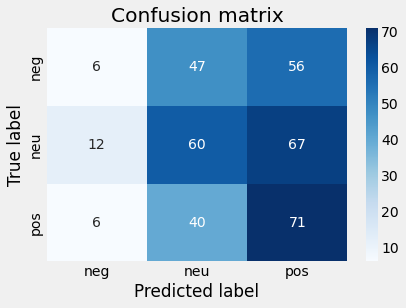


*** Precision, Recall, F1-measure per classe e media ***

                 neg       neu       pos       all
precision   0.250000  0.408163  0.365979  0.341381
recall      0.055046  0.431655  0.606838  0.364513
f1_measure  0.090226  0.419580  0.456592  0.322133

*** Gain, ROI ***

Gain: 2288.22$
 ROI: 6.03%

*** Calcolo intervallo di confidenza con Confidenza=0.95 con N=365 per accuracy e f1-measure ***

accuracy: (0.37534246575342467), intervallo confidenza: (0.3272082275989834, 0.426073303465999)
f1-measure: (0.32213254112052553), intervallo confidenza: (0.2762600852046008, 0.37170995211938285)


In [112]:
mlp_acc, mlp_f1, mlp_roi = eval_model(X_tss_test, y_tss_test, mlp_gs, verbose=True)
mlp_stats = [mlp_acc, mlp_f1, mlp_roi]

#### Modello casuale

In [113]:
rnd_model = Pipeline([
    ("preprocessor", preprocessor),
    ("dummy", DummyClassifier(strategy="uniform", random_state=rnd_state))
])

rnd_model.fit(X_tss_train, y_tss_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['month', 'weekday', 'semes'], dtype='object')),
                                                 ('text', TextTransformer(),
                                                  Index(['Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8',
       'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16',
       'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24',
       'Top25'],
      dtype='object'))])),
                ('dummy',
                 DummyClassifier(random_state=42, strategy='uniform'))])


*** Confusion matrix ***



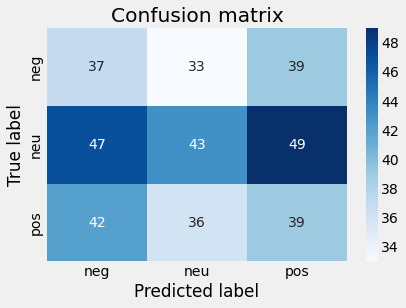


*** Precision, Recall, F1-measure per classe e media ***

                 neg       neu       pos       all
precision   0.293651  0.383929  0.307087  0.328222
recall      0.339450  0.309353  0.333333  0.327378
f1_measure  0.314894  0.342629  0.319672  0.325732

*** Gain, ROI ***

Gain: 380.25$
 ROI: 0.86%

*** Calcolo intervallo di confidenza con Confidenza=0.95 con N=365 per accuracy e f1-measure ***

accuracy: (0.32602739726027397), intervallo confidenza: (0.27996663628115803, 0.37571198399634487)
f1-measure: (0.32573174341351024), intervallo confidenza: (0.2796851458770171, 0.37540832513655104)


In [114]:
rnd_acc, rnd_f1, rnd_roi = eval_model(X_tss_test, y_tss_test, rnd_model, verbose=True)
rnd_stats = [rnd_acc, rnd_f1, rnd_roi]

## Valutazione dei modelli

In [115]:
x = PrettyTable()

x.field_names = ["Modelli", "Accuracy", "F1-Measure", "ROI"]

x.add_row(["Logistic Regression"] + logit_stats)
x.add_row(["SVM"] + svm_stats)
x.add_row(["Decision Tree"] + tree_stats)
x.add_row(["Random Forest"] + forest_stats)
x.add_row(["XGBoost"] + xgb_stats)
x.add_row(["Multi-layer Perceptron"] + mlp_stats)
x.add_row(["Modello casuale"] + rnd_stats)

print(x)

+------------------------+---------------------+---------------------+-------+
|        Modelli         |       Accuracy      |      F1-Measure     |  ROI  |
+------------------------+---------------------+---------------------+-------+
|  Logistic Regression   |  0.336986301369863  |  0.2889307447116778 |  0.51 |
|          SVM           | 0.37534246575342467 | 0.29907127015654905 | -0.51 |
|     Decision Tree      | 0.33424657534246577 | 0.29060536619115607 | -0.82 |
|     Random Forest      | 0.36712328767123287 |  0.3195488285469911 | -0.84 |
|        XGBoost         |  0.4054794520547945 | 0.33135984118643075 | 12.05 |
| Multi-layer Perceptron | 0.37534246575342467 | 0.32213254112052553 |  6.03 |
|    Modello casuale     | 0.32602739726027397 | 0.32573174341351024 |  0.86 |
+------------------------+---------------------+---------------------+-------+


Dai 6 modelli generati, si nota che `XGBoost`, `Multi-layer Perceptron` e `Random Forest` hanno un'<i>accuracy</i> più alta rispetto al modello casuale, mantenendo circa la stessa <i>F1-Measure</i>. Inoltre, tutti i modelli hanno problemi di <i>recall e F1-Measure</i> sulla classe (-1), la meno rappresentata. Non è possibile usare <i>"Smote"</i> per generare dati sintetici trattandosi di una serie temporale.<br>
Dei modelli considerati, si sceglie `XGBoost` e `Random Forest` per migliore <strong>explainability</strong> e poter interpretare la conoscenza appresa dall'analisi dei parametri appresi. <br> 

Si analizza coerenza e discrepanza  nei parametri appresi in entrambi i modelli per osservare ed estrapolare possibili pattern:

* `Sentiment`, la feature derivata dall'aggregazione delle previsioni del modello sottostante sul sentiment delle news giornaliere, è predominante per importanza per `XGBoost` e `Random Forest`;
* `Low, Volume, Open, High, Close`, le serie storiche sui cui è stato applicato il <i>fractional differencing</i> sono feature rilevanti per `XGBoost` e `Random Forest`;

Si nota come `XGBoost` dià importanza anche ad alcuni mesi particolari, denotando possibile <strong>sovradattamento</strong> ai dati.

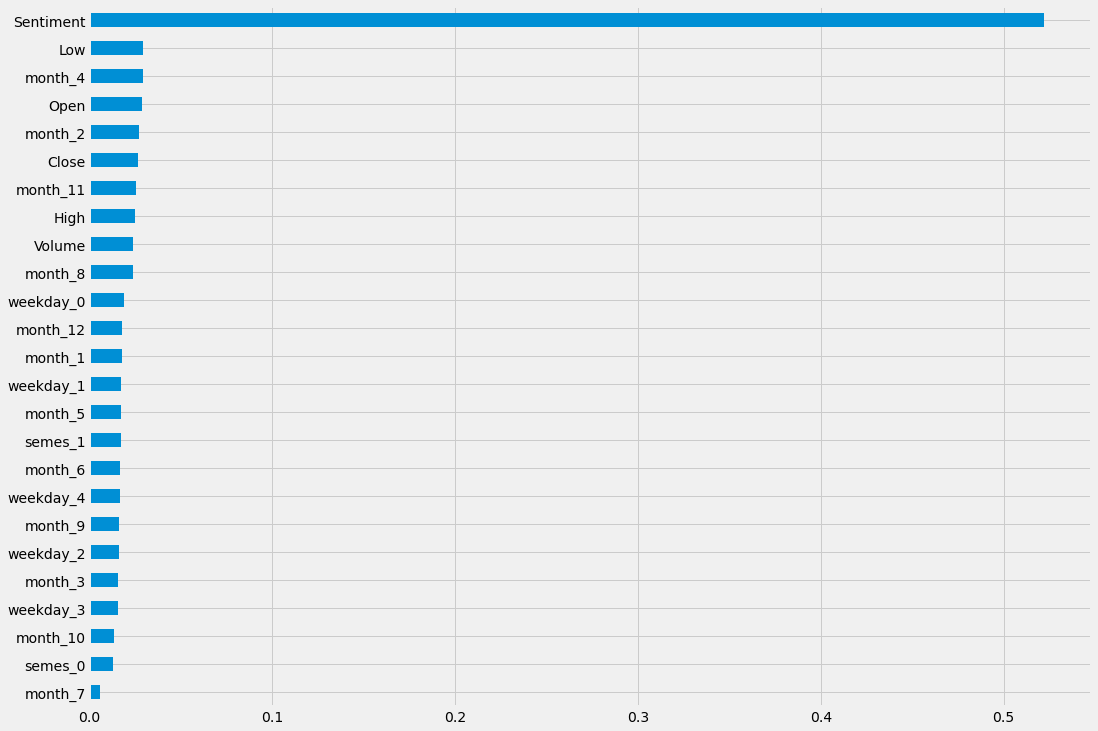

In [116]:
xgb_feature_importances = pd.Series(xgb_gs.best_estimator_.named_steps["xgb"].feature_importances_, index=coef_labels).sort_values(ascending=True)
xgb_feature_importances.plot(kind='barh', figsize=(16, 12));

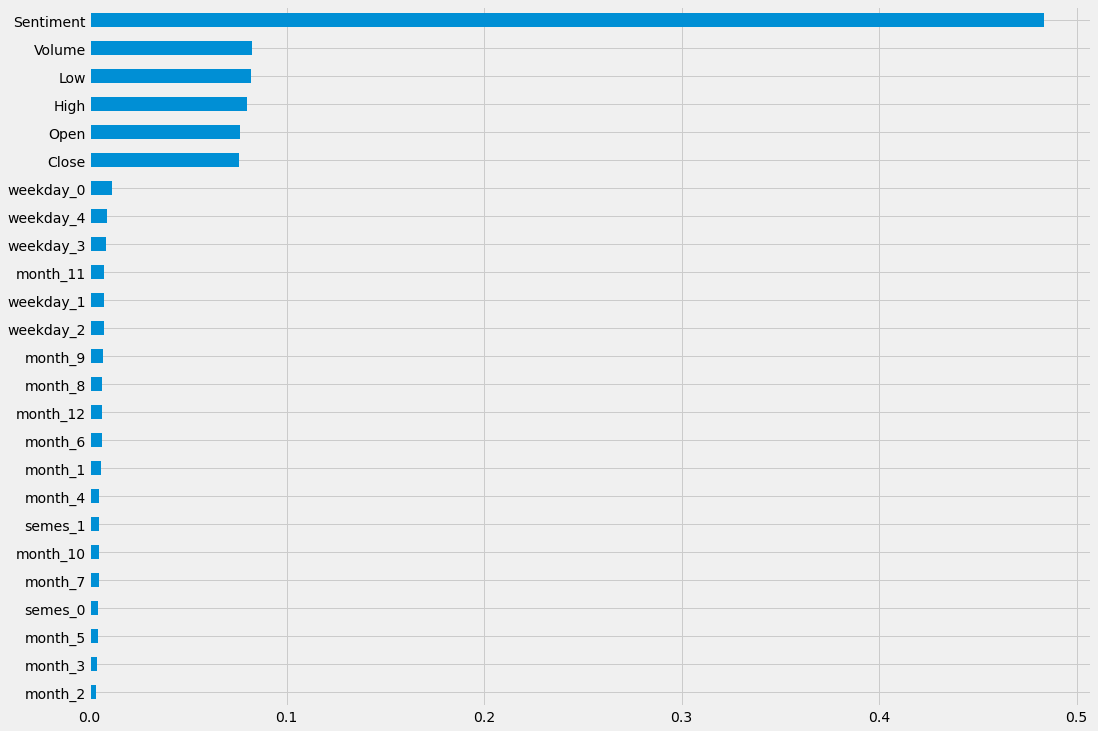

In [117]:
forest_feature_importances = pd.Series(forest_gs.best_estimator_.named_steps["forest"].feature_importances_, index=coef_labels).sort_values(ascending=True)
forest_feature_importances.plot(kind='barh', figsize=(16, 12));

Quale dei due modelli `XGBoost` e `Random Forest` è migliore? Per verificarlo bisogna valutare se la differenza $d$ tra le accuratezze sia <strong>statisticamente significativa</strong>, ovvero se l'intervallo di confidenza $d$ <u>non contiene lo zero</u>.

In [118]:
eval_difference_two_model(acc1=xgb_acc, acc2=forest_acc, N1=X_tss_test.shape[0], N2=X_tss_test.shape[0], alpha=0.05, confidence_level=True)


*** Valutazione statistica differenza tra modello 1 e modello 2 ***
(acc: 0.4054794520547945, N: 365) (acc: 0.36712328767123287, N: 365)


*** Valutazione soglia confidenza che rende significativa la differenza tra i due modelli ***
a: 0.29



(-0.032230101847876974, 0.10894243061500017)

* Con confidenza 0.95 la differenza è solo frutto del caso;
* La differenza diventa significativa quando la confidenza è < 0.81.

Data l'<i>accuracy</i> piuttosto bassa, si confronta `XGBoost` con il `modello casuale`, verificando se la differenza $d$ tra le accuratezze sia statisticamente significativa.

In [119]:
eval_difference_two_model(acc1=xgb_acc, acc2=rnd_acc, N1=X_tss_test.shape[0], N2=X_tss_test.shape[0], alpha=0.025, confidence_level=True)


*** Valutazione statistica differenza tra modello 1 e modello 2 ***
(acc: 0.4054794520547945, N: 365) (acc: 0.32602739726027397, N: 365)


*** Valutazione soglia confidenza che rende significativa la differenza tra i due modelli ***
a: 0.03



(-0.00018760866176070756, 0.15909171825080182)

* La differenza diventa significativa quando la confidenza è < 0.98.

## Conclusione

Sebbene i risultati non siano soddisfacenti, i margini di miglioramento sono ampi. Innanzitutto, si potrebbe utilizzare al posto delle news i tweets che hanno già una comprovata correlazione con l'andamento del mercato azionario, <a href="https://cris.unibo.it/handle/11585/678729#.YTt4r1uxXMM">filtrare tweets non rilevanti</a> e o con un lexicon finanziario o con un modello di learning e predire il sentiment giornaliero. <br> Inoltre, nella mia analisi mi sono concentrato solo su dati forniti dall'andamento del mercato finanziario; tolto questo limite, si potrebbe introdurre ulteriori feature, trattate con <i>fractional differing</i> tale da renderle stazionarie ma preservare la massima memoria possibile.<br>
Infine, si potrebbe costruire un <strong>Meta-Classifier</strong>, ovvero un modello secondario che determini se la predizione effettuata dal modello primario sia vera o falsa, filtrando <i>falsi positivi</i>. Questo non solo ci permetterebbe di identificare una <strong>trading opportunity</strong> ma anche di avere una <strong>size</strong> da impostare nel protocollo di trading, utilizzando la probabilità delle previsioni del modello secondario.